In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Configuration ---
OUTPUT_DIR = "./results"  # Or your actual path
# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy() # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique_vals_str = list(map(str, processed_df[col].unique())) # For robust printing
                if verbose: print(f"Column '{col}' before mapping. Unique values (as str): {original_unique_vals_str}")
                # Handle NaN mapping first if present in keys
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else: # No specific NaN mapping, just replace
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. New unique values: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns: # Check if column exists BEFORE trying to process
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()
                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric (were {original_nan_count}).")
                
                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' (listed in FLOAT_PRECISIONS) not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0.0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique(): # Check if 'No Attack' exists after mapping
            # Ensure ADV_RATE is numeric before this assignment
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD after mapping; ADV_RATE for 'No Attack' not set to 0.")
    
    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1,
    'discovery_quality': 1,
    'FINAL_MAIN_ACC': 4,
    'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_BENIGN_PAYMENT_GINI': 3, # Assuming this is AVG_BENIGN_PAYMENT_GINI from your CSV
    'AVG_ADVERSARY_SELECTION_RATE': 3, # This is the proportion of *selected* clients that are adversaries
    'AVG_BENIGN_SELLER_SELECTION_RATE': 3, # This might be rate among available benign, or proportion of selected
    'AVG_COST_PER_ROUND': 2, # Overall average cost per round
    'COST_OF_CONVERGENCE': 0, # Assuming integer rounds/costs
    'TOTAL_COST': 0,        # Assuming integer rounds/costs
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4': 3,
    # Add derived columns here if you want them rounded by the helper,
    # otherwise, round them after derivation.
    'AVG_COST_PER_ROUND_BENIGN': 2,
    'AVG_COST_PER_ROUND_MALICIOUS': 2
}

CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {
        'single': 'Data Poison', 
        np.nan: 'No Attack',  # Handles empty cells in CSV read as pandas NaN
        'None': 'No Attack',   # Handles cells with string 'None'
        'no_attack': 'No Attack' # Handles cells with string 'no_attack'
    },
    
    'attack_objective': {
        np.nan: 'No Attack',  # Handles empty cells in CSV read as pandas NaN
        'None': 'No Attack',   # Handles cells with string 'None'
        'no_attack': 'No Attack', # Handles cells with string 'no_attack'
        'backdoor': "Backdoor",
        'label_flip': "Label-Flipping",
    },
    'AGGREGATION_METHOD': {
        'martfl': "MartFL",
        'fedavg': 'FedAvg', 
        'fltrust': 'FLTrust',
        'skymask' : 'SkyMask',
    },
    'IS_SYBIL': {
        # Assuming your CSV has string 'False' and string 'mimic'
        # If it's boolean True/False, you'd map them:
        # True: 'mimic', 
        # False: 'False' # Keep 'False' as string 'False' for consistency
    }
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame() # Initialize as empty

try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS,
        verbose=True # Enable verbose output for debugging
    )
    
    # --- DERIVE COST COMPOSITION COLUMNS (Benign vs. Malicious Cost per Round) ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    
    # Check if derivation is sensible (i.e., source columns exist)
    if 'AVG_COST_PER_ROUND' in summary_df_avg.columns and \
       'AVG_ADVERSARY_SELECTION_RATE' in summary_df_avg.columns:
        
        print("Deriving cost composition (benign/malicious) from AVG_COST_PER_ROUND and AVG_ADVERSARY_SELECTION_RATE.")
        
        # Ensure source columns are numeric (they should be after preprocess_experiment_data if listed in FLOAT_PRECISIONS)
        # If not listed, convert them here explicitly before use.
        for col_to_check in ['AVG_COST_PER_ROUND', 'AVG_ADVERSARY_SELECTION_RATE']:
            if col_to_check not in FLOAT_PRECISIONS: # If not already processed by helper
                 if col_to_check in summary_df_avg.columns:
                    summary_df_avg[col_to_check] = pd.to_numeric(summary_df_avg[col_to_check], errors='coerce')
                    print(f"  Ensured column '{col_to_check}' is numeric for derivation.")
                 else:
                    print(f"  Warning: Source column '{col_to_check}' for derivation not found.")
                    # Create empty columns to prevent later key errors if derivation fails
                    summary_df_avg[cost_mal_col] = np.nan
                    summary_df_avg[cost_benign_col] = np.nan


        # For "No Attack" runs, AVG_ADVERSARY_SELECTION_RATE should be 0 for this calculation.
        # The preprocess_experiment_data sets ADV_RATE to 0.
        # Your data generation script should ensure AVG_ADVERSARY_SELECTION_RATE is 0 for No Attack runs.
        # If it might be NaN for No Attack runs, fill it with 0 before calculation.
        adv_sel_rate_for_calc = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].copy()
        # If ATTACK_METHOD is 'No Attack', this rate is definitionally 0.
        # Also, if it's NaN for an attack run (shouldn't happen if data is good), treat as 0 for safety here.
        adv_sel_rate_for_calc[summary_df_avg['ATTACK_METHOD'] == 'No Attack'] = 0.0
        adv_sel_rate_for_calc.fillna(0.0, inplace=True) # Fill any other NaNs with 0 to avoid NaN propagation

        # Calculate derived costs
        summary_df_avg[cost_mal_col] = summary_df_avg['AVG_COST_PER_ROUND'] * adv_sel_rate_for_calc
        summary_df_avg[cost_benign_col] = summary_df_avg['AVG_COST_PER_ROUND'] * (1 - adv_sel_rate_for_calc)
        
        # Round the newly derived columns if they weren't already in FLOAT_PRECISIONS
        # or if derivation might have introduced new float precision issues.
        if cost_mal_col in summary_df_avg.columns:
            summary_df_avg[cost_mal_col] = summary_df_avg[cost_mal_col].round(FLOAT_PRECISIONS.get(cost_mal_col, 2))
        if cost_benign_col in summary_df_avg.columns:
            summary_df_avg[cost_benign_col] = summary_df_avg[cost_benign_col].round(FLOAT_PRECISIONS.get(cost_benign_col, 2))
        print("Derived and processed cost composition columns.")
        
    else:
        print("Warning: Cannot derive cost composition. Missing 'AVG_COST_PER_ROUND' or 'AVG_ADVERSARY_SELECTION_RATE'.")
        # Ensure columns exist as NaN if derivation fails, for consistency in later plotting cells
        if cost_mal_col not in summary_df_avg.columns: summary_df_avg[cost_mal_col] = np.nan
        if cost_benign_col not in summary_df_avg.columns: summary_df_avg[cost_benign_col] = np.nan


    print(f"Processed summary_df_avg shape: {summary_df_avg.shape}")
    if not summary_df_avg.empty:
        print("\nFirst 5 rows of processed summary_df_avg (after potential derivation):")
        display(summary_df_avg.head())
        print("\nInfo of processed summary_df_avg:")
        summary_df_avg.info()

except FileNotFoundError:
    print(f"CRITICAL ERROR: summary_avg.csv not found in {OUTPUT_DIR}. Cannot proceed with plotting.")
    summary_df_avg = pd.DataFrame() # Ensure it's an empty DF if load fails
except Exception as e:
    print(f"CRITICAL ERROR: An error occurred during summary_df_avg loading or preprocessing: {e}")
    summary_df_avg = pd.DataFrame()

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
try:
    all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")
    print("\nall_rounds.csv loaded successfully.")
    all_rounds_df = preprocess_experiment_data(
        all_rounds_df_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS
    )
    print(f"Processed all_rounds_df shape: {all_rounds_df.shape}")
    if not all_rounds_df.empty: display(all_rounds_df.head())
except FileNotFoundError:
    print(f"Error: all_rounds.csv not found in {OUTPUT_DIR}. Please check the path.")
    all_rounds_df = pd.DataFrame()

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# --- Verification ---
if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---")
    check_cols = [
        'AGGREGATION_METHOD', 'ATTACK_METHOD', 'IS_SYBIL', 'ADV_RATE',
        'BENIGN_PAYMENT_GINI_COEFFICIENT', # This is your AVG_BENIGN_PAYMENT_GINI
        'AVG_BENIGN_SELLER_SELECTION_RATE', 
        'AVG_ADVERSARY_SELECTION_RATE',
        'AVG_COST_PER_ROUND_BENIGN', # New derived/processed
        'AVG_COST_PER_ROUND_MALICIOUS', # New derived/processed
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    ]
    for col in check_cols:
        if col in summary_df_avg.columns:
            unique_vals = summary_df_avg[col].unique()
            try:
                if pd.api.types.is_numeric_dtype(summary_df_avg[col].dtype) and not summary_df_avg[col].empty:
                    valid_numeric_vals = summary_df_avg[col].dropna().unique()
                    unique_vals = sorted(list(valid_numeric_vals)) if len(valid_numeric_vals) > 0 else []
                elif not summary_df_avg[col].empty:
                    # Attempt to sort strings, handle mixed types by converting all to string for sorting
                    unique_vals = sorted(list(map(str, unique_vals)))
            except TypeError:
                 print(f"    (Could not sort unique values for {col} due to mixed types or NaNs)")
                 pass 
            print(f"Unique values in '{col}': {unique_vals}")
            print(f"  NaNs in '{col}': {summary_df_avg[col].isna().sum()}")
        else:
            print(f"VERIFICATION WARNING: Column '{col}' NOT FOUND in processed summary_df_avg.")
else:
    print("\nsummary_df_avg is empty. Verification skipped. Subsequent plots will likely fail.")

--- Preprocessing summary_avg.csv ---
Column 'ATTACK_METHOD' before mapping. Unique values (as str): ['single', 'nan']
Column 'ATTACK_METHOD' mapped. New unique values: ['Data Poison' 'No Attack']
Column 'AGGREGATION_METHOD' before mapping. Unique values (as str): ['martfl']
Column 'AGGREGATION_METHOD' mapped. New unique values: ['MartFL']
Column 'IS_SYBIL' before mapping. Unique values (as str): ['False', 'mimic']
Column 'IS_SYBIL' mapped. New unique values: ['False' 'mimic']
Processing float column: ADV_RATE with precision 1
  Column 'ADV_RATE' rounded. NaNs after rounding: 0
Processing float column: discovery_quality with precision 1
  Column 'discovery_quality' rounded. NaNs after rounding: 0
Processing float column: FINAL_MAIN_ACC with precision 4
  Column 'FINAL_MAIN_ACC' rounded. NaNs after rounding: 0
Processing float column: FINAL_ASR with precision 4
  Column 'FINAL_ASR' rounded. NaNs after rounding: 0
Processing float column: PAYMENT_GINI_COEFFICIENT with precision 3
  Colum

,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,ROUNDS_TO_85ACC,COST_TO_85ACC,ROUNDS_TO_90ACC,COST_TO_90ACC,NO_ATTACK_DESIG_MAL_SEL_RATE_0.1,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4,AVG_COST_PER_ROUND_MALICIOUS,AVG_COST_PER_ROUND_BENIGN
0,2,MartFL,discovery,0.1,random,30.0,Data Poison,0.1,False,0.2,...,20.333333,395.666667,NaN,NaN,NaN,NaN,NaN,NaN,1.84,13.40
1,9,MartFL,discovery,0.1,biased,30.0,Data Poison,0.1,False,0.2,...,28.300000,528.900000,NaN,NaN,NaN,NaN,NaN,NaN,1.82,14.17
2,3,MartFL,discovery,1.0,random,30.0,Data Poison,0.1,False,0.2,...,18.250000,320.750000,NaN,NaN,NaN,NaN,NaN,NaN,2.53,12.29
3,9,MartFL,discovery,1.0,biased,30.0,Data Poison,0.1,False,0.2,...,25.300000,448.800000,NaN,NaN,NaN,NaN,NaN,NaN,2.54,13.35
4,0,MartFL,discovery,10.0,random,30.0,Data Poison,0.1,False,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,6.88



Info of processed summary_df_avg:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   run                                     186 non-null    int64  
 1   AGGREGATION_METHOD                      186 non-null    object 
 2   DATA_SPLIT_MODE                         186 non-null    object 
 3   discovery_quality                       186 non-null    float64
 4   buyer_data_mode                         186 non-null    object 
 5   N_CLIENTS                               186 non-null    float64
 6   ATTACK_METHOD                           186 non-null    object 
 7   TRIGGER_RATE                            186 non-null    float64
 8   IS_SYBIL                                186 non-null    object 
 9   ADV_RATE                                186 non-null    float64
 10  CHANGE_BASE                

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1092008\3580043665.py:201: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")


,run,round,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,TRIGGER_MODE,benign_rounds,trigger_mode,...,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2_ROUND,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3_ROUND,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4_ROUND,main_acc,main_loss,clean_acc,triggered_acc,asr,avg_selected_data_distribution_similarity,avg_unselected_data_distribution_similarity
0,0,0,Data Poison,0.1,False,0.2,True,static,0,static,...,NaN,NaN,NaN,0.5518,1.175421,0.5518,0.5701,0.1184,0.998623,0.998623
1,0,1,Data Poison,0.1,False,0.2,True,static,0,static,...,NaN,NaN,NaN,0.6757,0.824391,0.6757,0.6704,0.1236,0.998641,0.998623
2,0,2,Data Poison,0.1,False,0.2,True,static,0,static,...,NaN,NaN,NaN,0.7089,0.709304,0.7089,0.6917,0.1114,0.998603,0.998623
3,0,3,Data Poison,0.1,False,0.2,True,static,0,static,...,NaN,NaN,NaN,0.7316,0.654981,0.7316,0.7118,0.0949,0.998700,0.998623
4,0,4,Data Poison,0.1,False,0.2,True,static,0,static,...,NaN,NaN,NaN,0.7550,0.616033,0.7550,0.7322,0.1147,0.998637,0.998623



--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---
Unique values in 'AGGREGATION_METHOD': ['MartFL']
  NaNs in 'AGGREGATION_METHOD': 0
Unique values in 'ATTACK_METHOD': ['Data Poison', 'No Attack']
  NaNs in 'ATTACK_METHOD': 0
Unique values in 'IS_SYBIL': ['False', 'mimic']
  NaNs in 'IS_SYBIL': 0
Unique values in 'ADV_RATE': [np.float64(0.0), np.float64(0.2), np.float64(0.3), np.float64(0.4)]
  NaNs in 'ADV_RATE': 0
VERIFICATION WARNING: Column 'BENIGN_PAYMENT_GINI_COEFFICIENT' NOT FOUND in processed summary_df_avg.
Unique values in 'AVG_BENIGN_SELLER_SELECTION_RATE': [np.float64(0.22), np.float64(0.225), np.float64(0.246), np.float64(0.262), np.float64(0.292), np.float64(0.295), np.float64(0.298), np.float64(0.304), np.float64(0.328), np.float64(0.329), np.float64(0.33), np.float64(0.34), np.float64(0.341), np.float64(0.347), np.float64(0.355), np.float64(0.357), np.float64(0.362), np.float64(0.365), np.float64(0.374), np.float64(0.387), np.float64(0.391),

In [58]:
TARGET_DATASET = "FMNIST"
AGG_METHOD_TO_ANALYZE = 'MartFL'  # or 'fltrust', 'fedavg'
ATTACK_TO_ANALYZE = 'Backdoor'  # or 'None'
adv_rates_to_plot_on_x_for_attack = [0.2, 0.3, 0.4]
CONFIG_ADV_RATE = 0.3
CONFIG_IS_SYBIL = 'mimic'         # Ensure this is after mapping in Cell 1
CONFIG_BUYER_MODE = 'random'      # Example
CONFIG_DISCOVERY_QUALITY = 1.0    # Example

In [59]:
import os  # For creating directories


def save_figure_as_pdf(fig, output_directory, base_filename, current_aggregation_method="MartFL",
                       adv_rate_config=None, attack_method_config=None, is_sybil_config=None,
                       other_details=None, dpi=300):
    """
    Saves the given matplotlib figure as a PDF with a descriptive filename.

    Args:
        fig (matplotlib.figure.Figure): The figure object to save.
        output_directory (str): The directory where the figure will be saved.
        base_filename (str): A base name for the figure (e.g., "coc_vs_adv_rate").
        current_aggregation_method (str, optional): Aggregator name. Defaults to "MartFL".
        adv_rate_config (float, optional): Specific ADV_RATE if the plot is for a fixed rate.
        attack_method_config (str, optional): Specific ATTACK_METHOD if fixed.
        is_sybil_config (str/bool, optional): Specific IS_SYBIL state if fixed.
        other_details (str, optional): Any other specific details for the filename.
        dpi (int, optional): Dots per inch for the saved figure.
    """
    if not fig:
        print("Error: No figure object provided to save_figure_as_pdf.")
        return

    # Sanitize components for filename
    agg_method_safe = current_aggregation_method.replace(" ", "_").lower()
    base_filename_safe = base_filename.replace(" ", "_").replace("/", "_").lower()

    filename_parts = [agg_method_safe, base_filename_safe]

    if attack_method_config and attack_method_config != 'No Attack':  # Only add attack details if an attack is present
        attack_safe = str(attack_method_config).replace(" ", "_").lower()
        filename_parts.append(f"atk_{attack_safe}")
        if is_sybil_config is not None:
            sybil_safe = str(is_sybil_config).lower()
            filename_parts.append(f"syb_{sybil_safe}")
        if adv_rate_config is not None:
            filename_parts.append(f"adv{str(adv_rate_config).replace('.', 'p')}")  # e.g., adv0p3

    if other_details:
        details_safe = str(other_details).replace(" ", "_").lower()
        filename_parts.append(details_safe)

    final_filename = "_".join(filename_parts) + ".pdf"

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    full_save_path = os.path.join(output_directory, final_filename)

    try:
        # Use bbox_inches='tight' to minimize whitespace and ensure everything fits
        # pad_inches can add a little padding if 'tight' is too tight.
        fig.savefig(full_save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi)
        print(f"Figure saved successfully to: {full_save_path}")
    except Exception as e:
        print(f"Error saving figure to {full_save_path}: {e}")


FIGURE_SAVE_DIR = os.path.join(OUTPUT_DIR, "paper_figures")


In [60]:
import matplotlib as mpl

# Global font and style adjustments for compact multi-plot figure (e.g., 4 in a row)
mpl.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15,
    'legend.title_fontsize': 15,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'pdf.fonttype': 42,  # Ensure text is editable in PDFs
    'ps.fonttype': 42,
})

plt.rcParams["figure.figsize"] = (7.5, 5)  # adjust to your preferred size


Empty DataFrame
Columns: [run, AGGREGATION_METHOD, DATA_SPLIT_MODE, discovery_quality, buyer_data_mode, N_CLIENTS, ATTACK_METHOD, TRIGGER_RATE, IS_SYBIL, ADV_RATE, CHANGE_BASE, TRIGGER_MODE, benign_rounds, trigger_mode, MAX_ASR, FINAL_ASR, FINAL_MAIN_ACC, FINAL_CLEAN_ACC, FINAL_TRIGGERED_ACC, AVG_SELECTED_DISTRIBUTION_SIMILARITY, AVG_UNSELECTED_DISTRIBUTION_SIMILARITY, AVG_ADVERSARY_SELECTION_RATE, AVG_BENIGN_SELECTION_RATE, AVG_COST_PER_ROUND, COST_OF_CONVERGENCE, TARGET_ACC_FOR_COC, COC_TARGET_REACHED_ROUND, PAYMENT_GINI_COEFFICIENT, TOTAL_COST, TOTAL_ROUNDS, AVG_BENIGN_SELLER_SELECTION_RATE, AVG_BENIGN_PAYMENT_GINI, ROUNDS_TO_70ACC, COST_TO_70ACC, ROUNDS_TO_75ACC, COST_TO_75ACC, ROUNDS_TO_80ACC, COST_TO_80ACC, ROUNDS_TO_85ACC, COST_TO_85ACC, ROUNDS_TO_90ACC, COST_TO_90ACC, NO_ATTACK_DESIG_MAL_SEL_RATE_0.1, NO_ATTACK_DESIG_MAL_SEL_RATE_0.2, NO_ATTACK_DESIG_MAL_SEL_RATE_0.3, NO_ATTACK_DESIG_MAL_SEL_RATE_0.4, AVG_COST_PER_ROUND_MALICIOUS, AVG_COST_PER_ROUND_BENIGN, attack_objective]
In

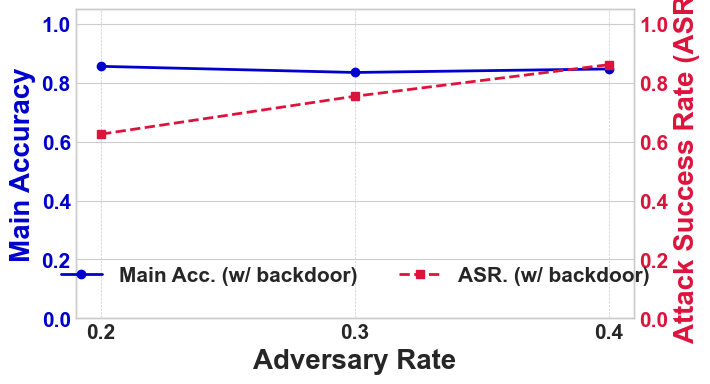

Figure saved successfully to: ./results\paper_figures\martfl_coc_vs_adv_rate.pdf


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For custom legend

# --- Assume summary_df_avg is loaded and your PREPROCESSING function is defined and used ---
# summary_df_avg = preprocess_experiment_data(...) # From your previous cell
if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy()
    # plot_data = plot_data[plot_data['DATASET'] == TARGET_DATASET]
    no_attack_perf = plot_data[plot_data['attack_objective'] == 'No Attack'].copy()
    print(no_attack_perf)
    if not no_attack_perf.empty:
        no_attack_avg_acc = no_attack_perf['FINAL_MAIN_ACC'].mean()
        no_attack_avg_asr = 0.1  # ASR for No Attack is 0
    else:
        no_attack_avg_acc = np.nan
        no_attack_avg_asr = np.nan

    backdoor_attack_filtered = plot_data[
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
        ].copy()

    if not backdoor_attack_filtered.empty:
        backdoor_attack_avg_perf = backdoor_attack_filtered.groupby('ADV_RATE', as_index=False)[
            ['FINAL_MAIN_ACC', 'FINAL_ASR']
        ].mean().sort_values(by='ADV_RATE')
        adv_rates_with_backdoor_data = sorted(backdoor_attack_avg_perf['ADV_RATE'].unique())
    else:
        backdoor_attack_avg_perf = pd.DataFrame(columns=['ADV_RATE', 'FINAL_MAIN_ACC', 'FINAL_ASR'])
        adv_rates_with_backdoor_data = []
        print(f"Warning: No 'Backdoor' data found for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")

    # --- Plotting ---
    # Font sizes for paper
    TITLE_FONT_SIZE = 14
    AXIS_LABEL_FONT_SIZE = 12
    TICK_LABEL_FONT_SIZE = 10
    LEGEND_FONT_SIZE = 9
    LEGEND_TITLE_FONT_SIZE = 10
    LINE_WIDTH = 2.0  # Slightly reduced from 2.5 for typical paper figs
    MARKER_SIZE = 6  # Slightly reduced

    fig, ax1 = plt.subplots()  # Adjusted for paper

    main_acc_color_attack = 'mediumblue'
    asr_color_attack = 'crimson'
    no_attack_acc_color = 'dimgray'  # Changed for better contrast with blue/red
    no_attack_asr_color = 'salmon'  # Changed for better contrast

    legend_elements = []
    x_min_for_no_attack_line = min(adv_rates_with_backdoor_data) if adv_rates_with_backdoor_data else 0.2
    x_max_for_no_attack_line = max(adv_rates_with_backdoor_data) if adv_rates_with_backdoor_data else 0.4

    # 1. Plot "No Attack" Main Accuracy
    if pd.notna(no_attack_avg_acc):
        ax1.hlines(y=no_attack_avg_acc, xmin=x_min_for_no_attack_line, xmax=x_max_for_no_attack_line,
                   color=no_attack_acc_color, linestyle=(0, (5, 5)), linewidth=LINE_WIDTH)  # Dash-dot style
        legend_elements.append(Line2D([0], [0], color=no_attack_acc_color, linestyle=(0, (5, 5)), lw=LINE_WIDTH,
                                      label=f'Main Acc. (no attack)'))

    # 2. Plot "Backdoor" Main Accuracy
    if not backdoor_attack_avg_perf.empty:
        ax1.plot(backdoor_attack_avg_perf['ADV_RATE'], backdoor_attack_avg_perf['FINAL_MAIN_ACC'],
                 color=main_acc_color_attack, linestyle='-', marker='o',
                 linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
        legend_elements.append(Line2D([0], [0], color=main_acc_color_attack, linestyle='-', marker='o', lw=LINE_WIDTH,
                                      label='Main Acc. (w/ backdoor)'))

    ax1.set_xlabel('Adversary Rate')
    ax1.set_ylabel('Main Accuracy', color=main_acc_color_attack)  # Color matches line
    ax1.tick_params(axis='y', labelcolor=main_acc_color_attack)
    ax1.set_ylim(0, 1.05)
    ax1.grid(True, which='major', linestyle=':', linewidth=0.5, axis='y')

    # 3. Second y-axis for ASR
    ax2 = ax1.twinx()

    # 4. Plot "No Attack" ASR
    if pd.notna(no_attack_avg_asr):
        ax2.hlines(y=no_attack_avg_asr, xmin=x_min_for_no_attack_line, xmax=x_max_for_no_attack_line,
                   color=no_attack_asr_color, linestyle=(0, (5, 5)), linewidth=LINE_WIDTH)  # Dash-dot style
        legend_elements.append(Line2D([0], [0], color=no_attack_asr_color, linestyle=(0, (5, 5)), lw=LINE_WIDTH,
                                      label=f'ASR. (no attack)'))

    # 5. Plot "Backdoor" ASR
    if not backdoor_attack_avg_perf.empty:
        ax2.plot(backdoor_attack_avg_perf['ADV_RATE'], backdoor_attack_avg_perf['FINAL_ASR'],
                 color=asr_color_attack, linestyle='--', marker='s',
                 linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
        legend_elements.append(
            Line2D([0], [0], color=asr_color_attack, linestyle='--', marker='s', lw=LINE_WIDTH, label='ASR. (w/ backdoor)'))

    ax2.set_ylabel('Attack Success Rate (ASR)', color=asr_color_attack)  # Color matches line
    ax2.tick_params(axis='y', labelcolor=asr_color_attack)
    ax2.set_ylim(0, 1.05)

    # 6. X-axis ticks
    if adv_rates_with_backdoor_data:
        ax1.set_xticks(ticks=adv_rates_with_backdoor_data)
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_data])
    else:
        ax1.set_xticks(ticks=[0.2, 0.3, 0.4])  # Fallback
        ax1.set_xticklabels(labels=['0.2', '0.3', '0.4'])
    ax1.tick_params(axis='x',)  # Ensure x-tick label size
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')

    # Legend: More compact, 2 columns below plot
    if legend_elements:
        legend_elements.sort(key=lambda x: ("No Attack" not in x.get_label(), "Main Acc" not in x.get_label()))
        fig.legend(handles=legend_elements,
                   loc='lower center',  # Place below plot
                   bbox_to_anchor=(0.5, 0.3),  # Adjust y for spacing below x-axis label
                   ncol=2,  # Try 2 columns for 4 items
                   frameon=False)  # Remove legend frame for cleaner look in paper

    # fig.suptitle(f'{current_aggregation_method}: Performance vs. ASR', fontsize=TITLE_FONT_SIZE, y=0.98,
    #              fontweight='bold')
    plt.tight_layout(
        rect=[0, 0.1, 1, 0.95])  # Adjust rect for suptitle and bottom legend (0.1 at bottom for legend space)
    # plt.savefig(f"{current_aggregation_method}_perf_vs_asr.pdf", bbox_inches='tight') # Example save
    
    plt.show()
    save_figure_as_pdf(
        fig=fig, 
        output_directory=FIGURE_SAVE_DIR, 
        base_filename="coc_vs_adv_rate", # Base name describing the plot
        current_aggregation_method=AGG_METHOD_TO_ANALYZE,
        # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
    )

    
else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_1092008\1304897151.py:83: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  valid_coc_plot_vals_current = pd.concat([


Figure saved successfully to: ./results\paper_figures\martfl_convergence_cost_varying_adv.pdf


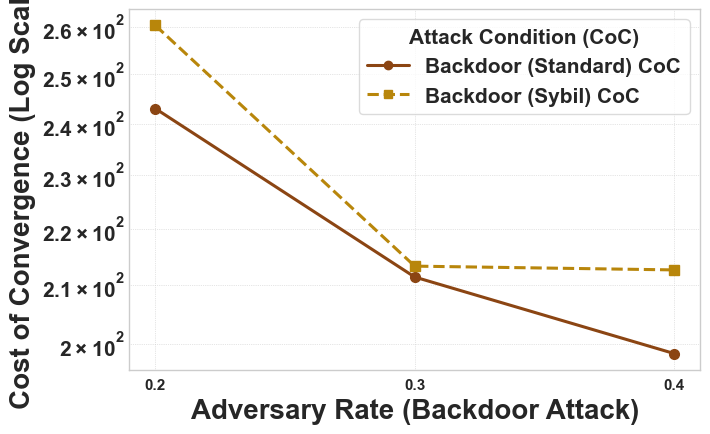

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_coc = summary_df_avg.copy()
    # Assuming AGGREGATION_METHOD is constant or you filter for a specific one
    aggregation_methods_present = plot_data_coc['AGGREGATION_METHOD'].unique()
    current_aggregation_method = AGG_METHOD_TO_ANALYZE
    if len(aggregation_methods_present) > 1:
        print(f"Warning (CoC Plot): Multiple aggregation methods. Plotting for '{current_aggregation_method}'.")
        plot_data_coc = plot_data_coc[plot_data_coc['AGGREGATION_METHOD'] == current_aggregation_method]

    TARGET_ACCURACY_COC = 0.85 # Ensure this matches your experiment setup for the title

    # Ensure COST_OF_CONVERGENCE_PLOT column is ready from Cell 1
    if 'COST_OF_CONVERGENCE_PLOT' not in plot_data_coc.columns:
        if 'COST_OF_CONVERGENCE' in plot_data_coc.columns: # Attempt to create it if base column exists
            plot_data_coc['COST_OF_CONVERGENCE'] = pd.to_numeric(plot_data_coc['COST_OF_CONVERGENCE'], errors='coerce')
            if 'TOTAL_COST' in plot_data_coc.columns:
                 plot_data_coc['TOTAL_COST'] = pd.to_numeric(plot_data_coc['TOTAL_COST'], errors='coerce')
                 plot_data_coc['COST_OF_CONVERGENCE_PLOT'] = plot_data_coc['COST_OF_CONVERGENCE'].fillna(plot_data_coc['TOTAL_COST'])
            else:
                 plot_data_coc['COST_OF_CONVERGENCE_PLOT'] = plot_data_coc['COST_OF_CONVERGENCE']
            plot_data_coc.dropna(subset=['COST_OF_CONVERGENCE_PLOT'], inplace=True)
        else:
            print("Error (CoC Plot): 'COST_OF_CONVERGENCE' or 'COST_OF_CONVERGENCE_PLOT' not found.")
            plot_data_coc = pd.DataFrame() # Prevent plotting

    if not plot_data_coc.empty and 'COST_OF_CONVERGENCE_PLOT' in plot_data_coc.columns and not plot_data_coc['COST_OF_CONVERGENCE_PLOT'].isna().all():
        no_attack_coc_data = plot_data_coc[plot_data_coc['attack_objective'] == 'No Attack'].copy()
        no_attack_baseline_coc = no_attack_coc_data['COST_OF_CONVERGENCE_PLOT'].mean() if not no_attack_coc_data.empty else np.nan

        adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
        backdoor_attack_coc_filtered = plot_data_coc[
            # (plot_data_coc['attack_objective'] == 'Backdoor') &
            (plot_data_coc['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        backdoor_coc_by_sybil = pd.DataFrame()
        adv_rates_present_coc = []
        if not backdoor_attack_coc_filtered.empty:
            backdoor_coc_by_sybil = backdoor_attack_coc_filtered.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )['COST_OF_CONVERGENCE_PLOT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_coc = sorted(backdoor_coc_by_sybil['ADV_RATE'].unique())

        # --- Plotting CoC ---
        if not backdoor_coc_by_sybil.empty or pd.notna(no_attack_baseline_coc):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7
            fig, ax = plt.subplots()

            colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'saddlebrown', 'Backdoor (Sybil)': 'darkgoldenrod' }
            linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Sybil)': '--' }
            markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Sybil)': 's' }
            legend_elements_coc = []

            xmin_hline = min(adv_rates_present_coc) if adv_rates_present_coc else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_coc) if adv_rates_present_coc else max(adv_rates_to_plot_on_x)

            if pd.notna(no_attack_baseline_coc):
                ax.hlines(y=no_attack_baseline_coc, xmin=xmin_hline, xmax=xmax_hline, color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
                legend_elements_coc.append(Line2D([0],[0],color=colors['No Attack'],lw=LINE_WIDTH,ls=linestyles['No Attack'],label=f'No Attack (CoC: {no_attack_baseline_coc:.0f})'))
            if not backdoor_coc_by_sybil.empty:
                data_std = backdoor_coc_by_sybil[backdoor_coc_by_sybil['IS_SYBIL'] == 'False'] # Assumes 'False' for Standard
                if not data_std.empty:
                    ax.plot(data_std['ADV_RATE'], data_std['COST_OF_CONVERGENCE_PLOT'], color=colors['Backdoor (Standard)'], marker=markers['Backdoor (Standard)'], ls=linestyles['Backdoor (Standard)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
                    legend_elements_coc.append(Line2D([0],[0],color=colors['Backdoor (Standard)'],lw=LINE_WIDTH,marker=markers['Backdoor (Standard)'],ls=linestyles['Backdoor (Standard)'],label='Backdoor (Standard) CoC'))
                data_mimic = backdoor_coc_by_sybil[backdoor_coc_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic.empty:
                    ax.plot(data_mimic['ADV_RATE'], data_mimic['COST_OF_CONVERGENCE_PLOT'], color=colors['Backdoor (Sybil)'], marker=markers['Backdoor (Sybil)'], ls=linestyles['Backdoor (Sybil)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
                    legend_elements_coc.append(Line2D([0],[0],color=colors['Backdoor (Sybil)'],lw=LINE_WIDTH,marker=markers['Backdoor (Sybil)'],ls=linestyles['Backdoor (Sybil)'],label='Backdoor (Sybil) CoC'))

            ax.set_xlabel('Adversary Rate (Backdoor Attack)')
            ax.set_ylabel(f'Cost of Convergence (Payments)',)
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            
            # Log Scale for CoC
            valid_coc_plot_vals_current = pd.concat([
                pd.Series([no_attack_baseline_coc] if pd.notna(no_attack_baseline_coc) else []),
                backdoor_coc_by_sybil['COST_OF_CONVERGENCE_PLOT'] if not backdoor_coc_by_sybil.empty else pd.Series([])
            ]).dropna()
            if not valid_coc_plot_vals_current.empty and (valid_coc_plot_vals_current > 0).all():
                ax.set_yscale('log'); ax.set_ylabel(f'Cost of Convergence (Log Scale)',)
            elif not valid_coc_plot_vals_current.empty :
                min_val = valid_coc_plot_vals_current.min(); ax.set_ylim(bottom=max(0, min_val*0.9 if pd.notna(min_val) else 0))
            
            plot_xticks_coc = adv_rates_present_coc if adv_rates_present_coc else adv_rates_to_plot_on_x
            if plot_xticks_coc: ax.set_xticks(ticks=plot_xticks_coc); ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_coc])
            ax.grid(True, which="both", ls=":", linewidth=0.5)
            if legend_elements_coc:
                ax.legend(handles=legend_elements_coc, title='Attack Condition (CoC)', loc='best', frameon=True, edgecolor='lightgray')
            # fig.suptitle(f'{current_aggregation_method}: Attack Impact on Convergence Cost (to {TARGET_ACCURACY_COC*100:.0f}% Acc.)', fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0,0,1,0.95])
            fig = plt.gcf()
            save_figure_as_pdf(
                fig=fig, 
                output_directory=FIGURE_SAVE_DIR, 
                base_filename="convergence_cost_varying_adv", # Base name describing the plot
                current_aggregation_method=current_aggregation_method,
                # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
            )
            plt.show()

        else:
            print("Not enough data for CoC plot after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available for CoC plot.")

     run AGGREGATION_METHOD DATA_SPLIT_MODE  discovery_quality  \
35     9             MartFL       discovery                0.1   
36     9             MartFL       discovery                0.1   
37     3             MartFL       discovery                1.0   
38     9             MartFL       discovery                1.0   
39     0             MartFL       discovery               10.0   
..   ...                ...             ...                ...   
181    9             MartFL       discovery                0.1   
182    3             MartFL       discovery                1.0   
183    9             MartFL       discovery                1.0   
184    0             MartFL       discovery               10.0   
185    9             MartFL       discovery               10.0   

    buyer_data_mode  N_CLIENTS ATTACK_METHOD  TRIGGER_RATE IS_SYBIL  ADV_RATE  \
35           random       30.0   Data Poison           0.1    mimic       0.2   
36           biased       30.0   Data Poison 

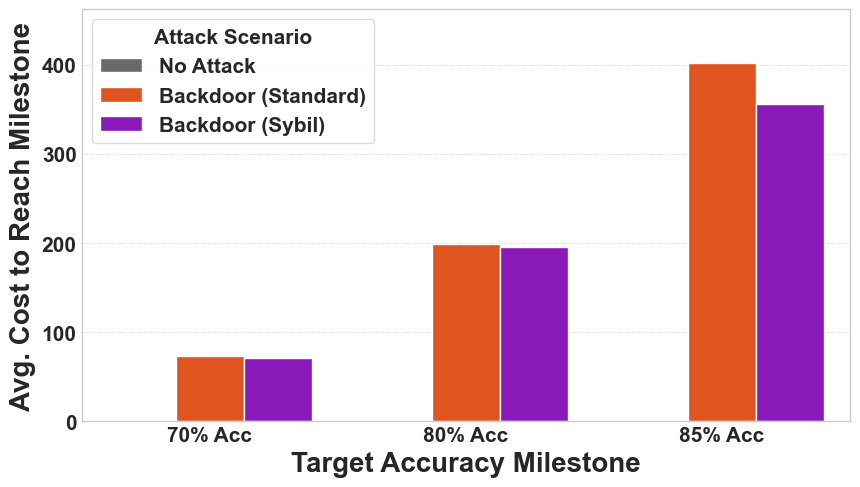

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn for barplot
import numpy as np

# This cell depends on 'summary_df_avg' being loaded and preprocessed by Cell 1,
# and containing the 'ROUNDS_TO_XXACC' columns.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_milestones = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Or get from df

    # --- Configuration for this plot ---
    # 1. CHOOSE THE FIXED ADVERSARY RATE for attack scenarios
    FIXED_ADV_RATE_FOR_COMPARISON = 0.3 # Example: Compare at 30% adversary rate
    
    # 2. CHOOSE THE ACCURACY MILESTONES to display on the X-axis
    # These must match the labels from your ROUNDS_TO_XXACC columns (e.g., "70", "80", "85")
    milestone_acc_labels_to_plot = ["70", "80", "85"] # Example
    milestone_cols_to_use = [f'COST_TO_{label}ACC' for label in milestone_acc_labels_to_plot]

    # Verify all chosen milestone columns exist
    missing_milestone_cols = [col for col in milestone_cols_to_use if col not in plot_data_milestones.columns]
    if missing_milestone_cols:
        print(f"Error (Milestone Bar Plot): Columns missing: {', '.join(missing_milestone_cols)}. Cannot create plot.")
    elif plot_data_milestones[milestone_cols_to_use].isna().all().all():
        print(f"Error (Milestone Bar Plot): All chosen milestone columns are entirely NaN.")
    else:
        # Ensure columns are numeric
        for col in milestone_cols_to_use:
            if col in plot_data_milestones.columns:
                 plot_data_milestones[col] = pd.to_numeric(plot_data_milestones[col], errors='coerce')
        
        # --- Prepare Data for Bar Chart ---
        data_for_bars = []

        # 1. No Attack Data (ADV_RATE is 0.0)
        no_attack_data = plot_data_milestones[plot_data_milestones['attack_objective'] == 'No Attack'].copy()
        if not no_attack_data.empty:
            for col, acc_label in zip(milestone_cols_to_use, milestone_acc_labels_to_plot):
                if col in no_attack_data.columns:
                    avg_rounds = no_attack_data[col].mean() # Average over IS_SYBIL for No Attack
                    if pd.notna(avg_rounds):
                        data_for_bars.append({'Condition': 'No Attack', 
                                              'Milestone': f'{acc_label}% Acc', 
                                              'Rounds to Converge': avg_rounds})

        # 2. Backdoor Attack (Standard) Data at FIXED_ADV_RATE_FOR_COMPARISON
        std_backdoor_data = plot_data_milestones[
            (plot_data_milestones['attack_objective'] == ATTACK_TO_ANALYZE) &
            (plot_data_milestones['IS_SYBIL'] == 'False') &
            (np.isclose(plot_data_milestones['ADV_RATE'], FIXED_ADV_RATE_FOR_COMPARISON))
        ].copy()
        if not std_backdoor_data.empty:
            for col, acc_label in zip(milestone_cols_to_use, milestone_acc_labels_to_plot):
                if col in std_backdoor_data.columns:
                    avg_rounds = std_backdoor_data[col].mean() # Should be one value if adv_rate is fixed
                    if pd.notna(avg_rounds):
                        data_for_bars.append({'Condition': 'Backdoor (Standard)', 
                                              'Milestone': f'{acc_label}% Acc', 
                                              'Rounds to Converge': avg_rounds})

        # 3. Backdoor Attack (Mimic) Data at FIXED_ADV_RATE_FOR_COMPARISON
        mimic_backdoor_data = plot_data_milestones[
            (plot_data_milestones['attack_objective'] == ATTACK_TO_ANALYZE) &
            (plot_data_milestones['IS_SYBIL'] == 'mimic') &
            (np.isclose(plot_data_milestones['ADV_RATE'], FIXED_ADV_RATE_FOR_COMPARISON))
        ].copy()
        print(plot_data_milestones[
            (plot_data_milestones['IS_SYBIL'] == 'mimic') 
        ])
        if not mimic_backdoor_data.empty:
            for col, acc_label in zip(milestone_cols_to_use, milestone_acc_labels_to_plot):
                if col in mimic_backdoor_data.columns:
                    avg_rounds = mimic_backdoor_data[col].mean()
                    if pd.notna(avg_rounds):
                        data_for_bars.append({'Condition': 'Backdoor (Sybil)', 
                                              'Milestone': f'{acc_label}% Acc', 
                                              'Rounds to Converge': avg_rounds})
        
        df_for_bars = pd.DataFrame(data_for_bars)

        # --- Plotting Grouped Bar Chart ---
        if not df_for_bars.empty:            
            plt.figure(figsize=(9, 5.5)) # Adjust size for clarity

            # Define a palette for the conditions
            condition_palette = {
                'No Attack': 'dimgray',
                'Backdoor (Standard)': 'orangered',
                'Backdoor (Sybil)': 'darkviolet'
            }
            
            # Order for milestones on x-axis
            milestone_order = [f"{label}% Acc" for label in milestone_acc_labels_to_plot]

            sns.barplot(
                data=df_for_bars,
                x='Milestone',
                y='Rounds to Converge',
                hue='Condition', # This groups the bars
                order=milestone_order, # Ensure milestones are in logical order
                hue_order=['No Attack', 'Backdoor (Standard)', 'Backdoor (Sybil)'], # Consistent legend order
                palette=condition_palette,
            )

            plt.xlabel('Target Accuracy Milestone')
            plt.ylabel('Avg. Cost to Reach Milestone')
            
            max_rounds_plot = df_for_bars['Rounds to Converge'].max()
            plt.ylim(0, max_rounds_plot * 1.15 if pd.notna(max_rounds_plot) else 200)


            plt.grid(True, which='major', linestyle=':', linewidth=0.6, axis='y')
            plt.gca().set_axisbelow(True) # Grid behind bars

            plt.legend(title='Attack Scenario', loc='upper left', frameon=True, edgecolor='lightgray')
            
            attack_adv_rate_info = ""
            if not no_attack_data.empty and (not std_backdoor_data.empty or not mimic_backdoor_data.empty):
                attack_adv_rate_info = f" (Attacks at {FIXED_ADV_RATE_FOR_COMPARISON*100:.0f}% Adversary Rate)"


            # plt.title(f'{current_aggregation_method}: Convergence Speed to Accuracy Milestones{attack_adv_rate_info}',
            #           fontsize=TITLE_FONT_SIZE, y=1.02, fontweight='bold')
            plt.tight_layout(rect=[0,0,1,0.96])
            # plt.savefig(f"{current_aggregation_method}_speed_to_milestones_adv{FIXED_ADV_RATE_FOR_COMPARISON}.pdf", bbox_inches='tight')
            fig = plt.gcf()
            save_figure_as_pdf(
                fig=fig, 
                output_directory=FIGURE_SAVE_DIR, 
                base_filename="milestone_cost", # Base name describing the plot
                current_aggregation_method=current_aggregation_method,
                # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
            )
            plt.show()
        else:
            print("Not enough data to create the milestone speed bar chart after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping milestone speed plot.")

Figure saved successfully to: ./results\paper_figures\martfl_milestone_round.pdf


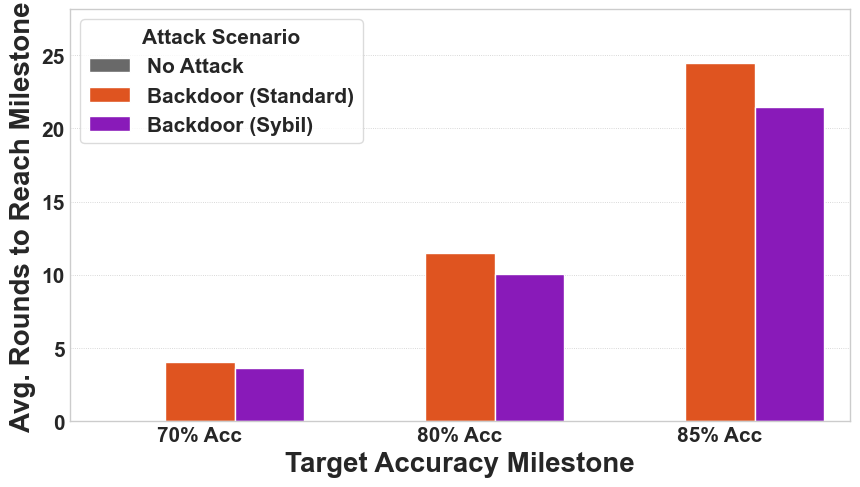

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn for barplot
import numpy as np

# This cell depends on 'summary_df_avg' being loaded and preprocessed by Cell 1,
# and containing the 'ROUNDS_TO_XXACC' columns.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_milestones = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Or get from df

    # --- Configuration for this plot ---
    # 1. CHOOSE THE FIXED ADVERSARY RATE for attack scenarios
    FIXED_ADV_RATE_FOR_COMPARISON = 0.3 # Example: Compare at 30% adversary rate
    
    # 2. CHOOSE THE ACCURACY MILESTONES to display on the X-axis
    # These must match the labels from your ROUNDS_TO_XXACC columns (e.g., "70", "80", "85")
    milestone_acc_labels_to_plot = ["70", "80", "85"] # Example
    milestone_cols_to_use = [f'ROUNDS_TO_{label}ACC' for label in milestone_acc_labels_to_plot]

    # Verify all chosen milestone columns exist
    missing_milestone_cols = [col for col in milestone_cols_to_use if col not in plot_data_milestones.columns]
    if missing_milestone_cols:
        print(f"Error (Milestone Bar Plot): Columns missing: {', '.join(missing_milestone_cols)}. Cannot create plot.")
    elif plot_data_milestones[milestone_cols_to_use].isna().all().all():
        print(f"Error (Milestone Bar Plot): All chosen milestone columns are entirely NaN.")
    else:
        # Ensure columns are numeric
        for col in milestone_cols_to_use:
            if col in plot_data_milestones.columns:
                 plot_data_milestones[col] = pd.to_numeric(plot_data_milestones[col], errors='coerce')
        
        # --- Prepare Data for Bar Chart ---
        data_for_bars = []

        # 1. No Attack Data (ADV_RATE is 0.0)
        no_attack_data = plot_data_milestones[plot_data_milestones['attack_objective'] == 'No Attack'].copy()
        if not no_attack_data.empty:
            for col, acc_label in zip(milestone_cols_to_use, milestone_acc_labels_to_plot):
                if col in no_attack_data.columns:
                    avg_rounds = no_attack_data[col].mean() # Average over IS_SYBIL for No Attack
                    if pd.notna(avg_rounds):
                        data_for_bars.append({'Condition': 'No Attack', 
                                              'Milestone': f'{acc_label}% Acc', 
                                              'Rounds to Converge': avg_rounds})

        # 2. Backdoor Attack (Standard) Data at FIXED_ADV_RATE_FOR_COMPARISON
        std_backdoor_data = plot_data_milestones[
            (plot_data_milestones['attack_objective'] == 'Backdoor') &
            (plot_data_milestones['IS_SYBIL'] == 'False') &
            (np.isclose(plot_data_milestones['ADV_RATE'], FIXED_ADV_RATE_FOR_COMPARISON))
        ].copy()
        if not std_backdoor_data.empty:
            for col, acc_label in zip(milestone_cols_to_use, milestone_acc_labels_to_plot):
                if col in std_backdoor_data.columns:
                    avg_rounds = std_backdoor_data[col].mean() # Should be one value if adv_rate is fixed
                    if pd.notna(avg_rounds):
                        data_for_bars.append({'Condition': 'Backdoor (Standard)', 
                                              'Milestone': f'{acc_label}% Acc', 
                                              'Rounds to Converge': avg_rounds})

        # 3. Backdoor Attack (Mimic) Data at FIXED_ADV_RATE_FOR_COMPARISON
        mimic_backdoor_data = plot_data_milestones[
            (plot_data_milestones['attack_objective'] == 'Backdoor') &
            (plot_data_milestones['IS_SYBIL'] == 'mimic') &
            (np.isclose(plot_data_milestones['ADV_RATE'], FIXED_ADV_RATE_FOR_COMPARISON))
        ].copy()
        if not mimic_backdoor_data.empty:
            for col, acc_label in zip(milestone_cols_to_use, milestone_acc_labels_to_plot):
                if col in mimic_backdoor_data.columns:
                    avg_rounds = mimic_backdoor_data[col].mean()
                    if pd.notna(avg_rounds):
                        data_for_bars.append({'Condition': 'Backdoor (Sybil)', 
                                              'Milestone': f'{acc_label}% Acc', 
                                              'Rounds to Converge': avg_rounds})
        
        df_for_bars = pd.DataFrame(data_for_bars)

        # --- Plotting Grouped Bar Chart ---
        if not df_for_bars.empty:
            
            plt.figure(figsize=(9, 5.5)) # Adjust size for clarity

            # Define a palette for the conditions
            condition_palette = {
                'No Attack': 'dimgray',
                'Backdoor (Standard)': 'orangered',
                'Backdoor (Sybil)': 'darkviolet'
            }
            
            # Order for milestones on x-axis
            milestone_order = [f"{label}% Acc" for label in milestone_acc_labels_to_plot]

            sns.barplot(
                data=df_for_bars,
                x='Milestone',
                y='Rounds to Converge',
                hue='Condition', # This groups the bars
                order=milestone_order, # Ensure milestones are in logical order
                hue_order=['No Attack', 'Backdoor (Standard)', 'Backdoor (Sybil)'], # Consistent legend order
                palette=condition_palette,
                # errorbar=None # If summary_df_avg already contains averages
            )

            plt.xlabel('Target Accuracy Milestone')
            plt.ylabel('Avg. Rounds to Reach Milestone')
            
            # Set y-limit (optional, adjust based on your data)
            max_rounds_plot = df_for_bars['Rounds to Converge'].max()
            plt.ylim(0, max_rounds_plot * 1.15 if pd.notna(max_rounds_plot) else 200)


            plt.grid(True, which='major', linestyle=':', linewidth=0.6, axis='y')
            plt.gca().set_axisbelow(True) # Grid behind bars

            plt.legend(title='Attack Scenario', loc='upper left', frameon=True, edgecolor='lightgray')
            
            attack_adv_rate_info = ""
            if not no_attack_data.empty and (not std_backdoor_data.empty or not mimic_backdoor_data.empty):
                attack_adv_rate_info = f" (Attacks at {FIXED_ADV_RATE_FOR_COMPARISON*100:.0f}% Adversary Rate)"


            # plt.title(f'{current_aggregation_method}: Convergence Speed to Accuracy Milestones{attack_adv_rate_info}',
            #           fontsize=TITLE_FONT_SIZE, y=1.02, fontweight='bold')
            plt.tight_layout(rect=[0,0,1,0.96])
            # plt.savefig(f"{current_aggregation_method}_speed_to_milestones_adv{FIXED_ADV_RATE_FOR_COMPARISON}.pdf", bbox_inches='tight')
            fig = plt.gcf()
            save_figure_as_pdf(
                fig=fig, 
                output_directory=FIGURE_SAVE_DIR, 
                base_filename="milestone_round", # Base name describing the plot
                current_aggregation_method=current_aggregation_method,
                # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
            )
            plt.show()

        else:
            print("Not enough data to create the milestone speed bar chart after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping milestone speed plot.")

Figure saved successfully to: ./results\paper_figures\martfl_convergence_cost_component_varying_adv.pdf


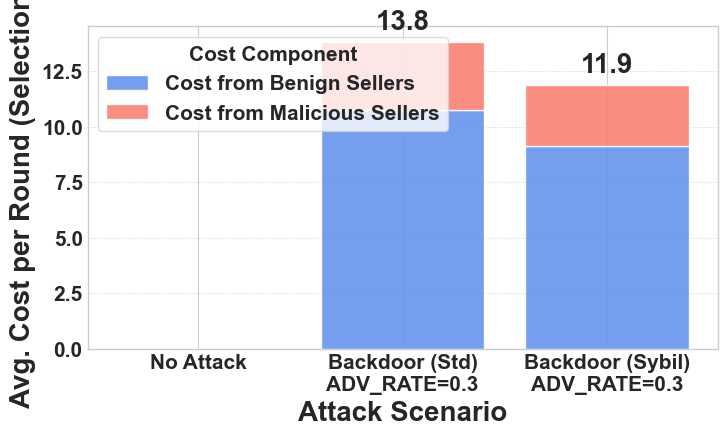

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.
# It requires 'AVG_COST_PER_ROUND_BENIGN' and 'AVG_COST_PER_ROUND_MALICIOUS'
# (which may have been derived in Cell 1).

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_cost_bar = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming 'MartFL'

    # --- Columns needed for cost composition ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    
    # Verify required columns exist and are not all NaN
    if not (cost_benign_col in plot_data_cost_bar.columns and cost_mal_col in plot_data_cost_bar.columns):
        print(f"Error (Cost Bar Plot): Cost composition columns ('{cost_benign_col}', '{cost_mal_col}') not found. Check Cell 1 derivation.")
    elif plot_data_cost_bar[[cost_benign_col, cost_mal_col]].isna().all().all():
        print(f"Error (Cost Bar Plot): Cost composition columns are entirely NaN.")
    else:
        # Ensure columns are numeric (already handled by preprocess_experiment_data if listed in FLOAT_PRECISIONS)
        # Drop rows if either essential cost component is NaN for this plot
        plot_data_cost_bar.dropna(subset=[cost_benign_col, cost_mal_col], how='any', inplace=True)

        # --- Prepare Data for the 3 Scenarios for Bar Chart ---
        # 1. No Attack Scenario (ADV_RATE is 0.0 for these)
        no_attack_cost_data = plot_data_cost_bar[plot_data_cost_bar['attack_objective'] == 'No Attack'].copy()
        # Average over IS_SYBIL for a single "No Attack" bar
        avg_no_attack_cost_benign = no_attack_cost_data[cost_benign_col].mean() if not no_attack_cost_data.empty else 0
        avg_no_attack_cost_mal = no_attack_cost_data[cost_mal_col].mean() if not no_attack_cost_data.empty else 0 # Should be 0

        # 2. Backdoor Attack (Standard) - at a specific ADV_RATE
        REPRESENTATIVE_ADV_RATE_FOR_ATTACK = 0.3 # Or choose another representative rate
        
        std_backdoor_data = plot_data_cost_bar[
            (plot_data_cost_bar['attack_objective'] == 'Backdoor') &
            (plot_data_cost_bar['IS_SYBIL'] == 'False') & # Standard
            (np.isclose(plot_data_cost_bar['ADV_RATE'], REPRESENTATIVE_ADV_RATE_FOR_ATTACK))
        ].copy()
        avg_std_backdoor_cost_benign = std_backdoor_data[cost_benign_col].mean() if not std_backdoor_data.empty else 0
        avg_std_backdoor_cost_mal = std_backdoor_data[cost_mal_col].mean() if not std_backdoor_data.empty else 0

        # 3. Backdoor Attack (Mimic) - at the same representative ADV_RATE
        mimic_backdoor_data = plot_data_cost_bar[
            (plot_data_cost_bar['attack_objective'] == 'Backdoor') &
            (plot_data_cost_bar['IS_SYBIL'] == 'mimic') &
            (np.isclose(plot_data_cost_bar['ADV_RATE'], REPRESENTATIVE_ADV_RATE_FOR_ATTACK))
        ].copy()
        avg_mimic_backdoor_cost_benign = mimic_backdoor_data[cost_benign_col].mean() if not mimic_backdoor_data.empty else 0
        avg_mimic_backdoor_cost_mal = mimic_backdoor_data[cost_mal_col].mean() if not mimic_backdoor_data.empty else 0

        # --- Data for Bar Chart ---
        scenarios = ['No Attack', f'Backdoor (Std)\nADV_RATE={REPRESENTATIVE_ADV_RATE_FOR_ATTACK}', 
                     f'Backdoor (Sybil)\nADV_RATE={REPRESENTATIVE_ADV_RATE_FOR_ATTACK}']
        benign_costs = [avg_no_attack_cost_benign, avg_std_backdoor_cost_benign, avg_mimic_backdoor_cost_benign]
        malicious_costs = [avg_no_attack_cost_mal, avg_std_backdoor_cost_mal, avg_mimic_backdoor_cost_mal]

        # --- Plotting Stacked Bar Chart ---
        if any(pd.notna(c) for c in benign_costs + malicious_costs) and any(c > 0 for c in benign_costs + malicious_costs):
            fig, ax = plt.subplots()

            x_pos = np.arange(len(scenarios))

            bar1 = ax.bar(x_pos, benign_costs, label='Cost from Benign Sellers', color='cornflowerblue', alpha=0.9)
            bar2 = ax.bar(x_pos, malicious_costs, bottom=benign_costs, label='Cost from Malicious Sellers', color='salmon', alpha=0.9)

            ax.set_xlabel('Attack Scenario', )
            ax.set_ylabel('Avg. Cost per Round (Selections)')
            ax.tick_params(axis='y')
            
            ax.set_xticks(x_pos)
            ax.set_xticklabels(scenarios, rotation=0, ha="center")

            # Add values on top of bars for total cost
            for i in range(len(x_pos)):
                total_height = (benign_costs[i] if pd.notna(benign_costs[i]) else 0) + \
                               (malicious_costs[i] if pd.notna(malicious_costs[i]) else 0)
                if total_height > 0: # Only add text if bar has height
                     ax.text(x_pos[i], total_height + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), # Position above bar
                            f'{total_height:.1f}', ha='center', va='bottom', fontweight='bold')

            ax.grid(True, which='major', linestyle=':', linewidth=0.6, axis='y'); ax.set_axisbelow(True)
            ax.legend(title='Cost Component', loc='upper left', frameon=True, edgecolor='lightgray')
            # fig.suptitle(f'{current_aggregation_method}: Composition of Avg. Cost per Round by Attack Scenario', fontsize=TITLE_FONT_SIZE, y=0.98, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            fig = plt.gcf()
            save_figure_as_pdf(
                fig=fig, 
                output_directory=FIGURE_SAVE_DIR, 
                base_filename="convergence_cost_component_varying_adv", # Base name describing the plot
                current_aggregation_method=current_aggregation_method,
                # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
            )
        else:
            print("Not enough data to plot Cost Composition bar chart after filtering for specific scenarios.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping Cost Composition plot.")

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This cell depends on 'all_rounds_df' being loaded and preprocessed by Cell 1.
# It should contain per-round 'main_acc', 'asr', 'round', 'AGGREGATION_METHOD',
# and other CONFIG_ columns like 'ADV_RATE', 'attack_objective', 'IS_SYBIL', etc.

# --- Example: For standalone testing, ensure all_rounds_df exists ---
# if 'all_rounds_df' not in locals() or all_rounds_df.empty:
#     print("INFO: 'all_rounds_df' not found or empty. Creating a dummy DataFrame for demonstration.")
#     num_rounds_dummy = 50; agg_methods_dummy = ['MartFL', 'FedAvg']
#     dummy_round_data_list = []
#     for agg_m in agg_methods_dummy:
#         for r in range(num_rounds_dummy):
#             dummy_round_data_list.append({
#                 'AGGREGATION_METHOD': agg_m, 'attack_objective': 'Backdoor', 'IS_SYBIL': 'mimic',
#                 'ADV_RATE': 0.3, 'buyer_data_mode': 'random', 'discovery_quality': 1.0, 'round': r,
#                 'main_acc': 0.5 + (r/num_rounds_dummy*0.3) + np.random.normal(0,0.02) - (0.05 if agg_m=='FedAvg' else 0),
#                 'asr': 0.6 - (r/num_rounds_dummy*0.4) + np.random.normal(0,0.03) + (0.1 if agg_m=='FedAvg' else 0),
#                 'cost_per_round': 10 + np.random.randint(-2,2)
#             })
#     all_rounds_df = pd.DataFrame(dummy_round_data_list)
#     for col in ['main_acc', 'asr', 'cost_per_round']:
#          all_rounds_df[col] = pd.to_numeric(all_rounds_df[col], errors='coerce').clip(0,1) # Clip acc/asr to 0-1
#     all_rounds_df['round'] = pd.to_numeric(all_rounds_df['round'], errors='coerce')


if 'all_rounds_df' in locals() and not all_rounds_df.empty:
    # --- Configuration for this specific plot instance ---
    # Define the FIXED parameters for which you want to see the time series

    # CONFIG_DATASET = 'FMNIST' # Optional filter

    # Filter data for the specific configuration
    # Note: Ensure column names and values match those in your preprocessed all_rounds_df
    query_parts = [
        f"ADV_RATE == {CONFIG_ADV_RATE}",
        f"attack_objective == '{ATTACK_TO_ANALYZE}'",
        f"IS_SYBIL == '{CONFIG_IS_SYBIL}'",
        f"buyer_data_mode == '{CONFIG_BUYER_MODE}'",
        f"discovery_quality == {CONFIG_DISCOVERY_QUALITY}"
    ]
    # if CONFIG_DATASET: query_parts.append(f"dataset_name == '{CONFIG_DATASET}'") # Example if dataset_name column exists

    # Check if all config columns exist before querying
    config_cols_for_query = ['ADV_RATE', 'attack_objective', 'IS_SYBIL', 'buyer_data_mode', 'discovery_quality'] # Add others if used
    missing_query_cols = [col for col in config_cols_for_query if col not in all_rounds_df.columns]
    if missing_query_cols:
        print(f"Error (Time Series Plot): Config columns missing from all_rounds_df: {missing_query_cols}")
        base_time_series_df = pd.DataFrame() # Prevent error
    else:
        try:
            base_time_series_df = all_rounds_df.query(" & ".join(query_parts)).copy()
        except pd.errors.UndefinedVariableError as e:
            print(f"Error querying DataFrame (check column names and quoting): {e}")
            base_time_series_df = pd.DataFrame()
        except Exception as e:
            print(f"An unexpected error occurred during DataFrame query: {e}")
            base_time_series_df = pd.DataFrame()


    if not base_time_series_df.empty:
        # The 'hue' for seaborn lineplot will be 'AGGREGATION_METHOD'.
        # Group by 'AGGREGATION_METHOD' and 'round' to average if multiple runs exist FOR THE SAME AGG METHOD
        # under the exact same CONFIG_... settings.
        # If 'run' column (from process_single_experiment) is part of all_rounds_df and you averaged runs already to get summary_df_avg,
        # then for all_rounds_df, each (AGG_METHOD, round) under a config might be unique if it's from one specific run's log.
        # If multiple runs were concatenated into all_rounds_df, then averaging is needed.
        
        grouping_cols = ['AGGREGATION_METHOD', 'round']
        # Add other columns to grouping_cols if they vary within this slice and you want separate lines for them.
        # Example: if 'CHANGE_BASE' is a relevant varying parameter for MartFL:
        # if 'CHANGE_BASE' in base_time_series_df.columns and 'MartFL' in base_time_series_df['AGGREGATION_METHOD'].unique():
        #    grouping_cols.insert(1, 'CHANGE_BASE')

        metrics_to_avg = ['main_acc', 'asr'] # Add 'cost_per_round' if you want to plot it
        # Check if metrics_to_avg exist
        missing_metric_cols = [col for col in metrics_to_avg if col not in base_time_series_df.columns]
        if missing_metric_cols:
            print(f"Error (Time Series Plot): Metric columns missing: {missing_metric_cols}")
            averaged_time_series_df = pd.DataFrame()
        else:
            # Ensure metrics are numeric before averaging
            for col in metrics_to_avg:
                base_time_series_df[col] = pd.to_numeric(base_time_series_df[col], errors='coerce')
            base_time_series_df.dropna(subset=metrics_to_avg, how='any', inplace=True) # Drop if key metrics are NaN

            if not base_time_series_df.empty:
                averaged_time_series_df = base_time_series_df.groupby(grouping_cols, as_index=False)[metrics_to_avg].mean()
            else:
                averaged_time_series_df = pd.DataFrame()


        if not averaged_time_series_df.empty:
            LINE_WIDTH = 2.0 

            # Determine number of subplots based on metrics to plot
            num_subplots = len(metrics_to_avg)
            fig, axes = plt.subplots(num_subplots, 1, figsize=(7, 3.5 * num_subplots), sharex=True) # Compact width
            if num_subplots == 1: axes = [axes] # Make iterable

            # Determine if legend is needed
            unique_aggregators = averaged_time_series_df['AGGREGATION_METHOD'].nunique()
            show_legend = unique_aggregators > 1

            # Define a palette if multiple aggregators
            palette = sns.color_palette("tab10", unique_aggregators) if show_legend else None

            # Plot Main Accuracy
            if 'main_acc' in averaged_time_series_df.columns:
                sns.lineplot(data=averaged_time_series_df, x="round", y="main_acc",
                             hue="AGGREGATION_METHOD" if show_legend else None, 
                             palette=palette,
                             linewidth=LINE_WIDTH, ax=axes[0], 
                             legend="brief" if show_legend and num_subplots > 1 else "full" if show_legend else False, # Legend on first plot
                             errorbar=('ci', 95) # If groupby averages multiple original runs
                            )
                axes[0].set_title(f'Avg. Main Accuracy') # Simplified title
                axes[0].set_ylabel('Accuracy')
                axes[0].grid(True, linestyle=':', linewidth=0.6)
                # axes[0].tick_params(labelsize=TICK_LABEL_FONT_SIZE)
                axes[0].set_ylim(-0.02, 1.02)


            # Plot ASR
            if 'asr' in averaged_time_series_df.columns:
                ax_asr = axes[1] if num_subplots > 1 else axes[0] # Use same axis if only one metric
                if ATTACK_TO_ANALYZE != 'No Attack' and 'asr' in averaged_time_series_df.columns:
                    sns.lineplot(data=averaged_time_series_df, x="round", y="asr",
                                 hue="AGGREGATION_METHOD" if show_legend else None,
                                 palette=palette,
                                 linewidth=LINE_WIDTH, ax=ax_asr, legend=False, # No redundant legend
                                 errorbar=('ci', 95)
                                )
                    ax_asr.set_title(f'Avg. Attack Success Rate (ASR)') # Simplified
                    ax_asr.set_ylabel('ASR')
                elif 'asr' in averaged_time_series_df.columns: # If 'asr' exists but it's a No Attack scenario
                    ax_asr.set_title('ASR (No Attack Scenario)',)
                    ax_asr.text(0.5, 0.5, 'No Attack', ha='center', va='center', transform=ax_asr.transAxes)
                ax_asr.grid(True, linestyle=':', linewidth=0.6)
                # ax_asr.tick_params(labelsize=TICK_LABEL_FONT_SIZE)
                ax_asr.set_ylim(-0.02, 1.02)


            # Set common X-axis label for the last subplot
            axes[-1].set_xlabel('Communication Round')

            # Handle legend if it was created on the first plot and there are multiple aggregators
            if show_legend and num_subplots > 1 and axes[0].get_legend() is not None:
                handles, labels = axes[0].get_legend_handles_labels()
                axes[0].get_legend().remove() # Remove from subplot
                fig.legend(handles, labels, title='Aggregator', loc='upper center', 
                           bbox_to_anchor=(0.5, 0.01), ncol=unique_aggregators, frameon=False)
                fig_rect_bottom = 0.12 if unique_aggregators <=3 else 0.15 # More space if more legend items
            elif show_legend and num_subplots == 1 and axes[0].get_legend() is not None: # Legend inside for single plot
                 plt.setp(axes[0].get_legend().get_texts(),)
                 plt.setp(axes[0].get_legend().get_title(),)
                 fig_rect_bottom = 0.05
            else: # No legend shown
                fig_rect_bottom = 0.05


            # Concise suptitle
            suptitle_text = f'{current_aggregation_method if not show_legend else "Comparison"}: Time Series'
            # Add key config details to suptitle if needed, or keep it simple
            # suptitle_text += f"\n(AdvRate:{CONFIG_ADV_RATE}, Atk:{CONFIG_ATTACK_METHOD.replace('Backdoor','BD')}, Syb:{CONFIG_IS_SYBIL}, Buyer:{CONFIG_BUYER_MODE}, DQ:{CONFIG_DISCOVERY_QUALITY})"
            fig.suptitle(suptitle_text, y=1.0, fontweight='bold') # Adjust y
            
            plt.tight_layout(rect=[0, fig_rect_bottom, 1, 0.95]) # Adjust rect for legend and suptitle
            plt.show()
        else:
            print("Averaged time series data is empty. Check grouping columns and filters, or if source metrics were all NaN.")
    else:
        print(f"No data found for the specified time series configuration. Query parts: {' & '.join(query_parts)}")
else:
    print("DataFrame 'all_rounds_df' is not available (empty or not loaded). Skipping Time Series plot.")

Error (Time Series Plot): Config columns missing from all_rounds_df: ['attack_objective']
No data found for the specified time series configuration. Query parts: ADV_RATE == 0.3 & attack_objective == 'Backdoor' & IS_SYBIL == 'mimic' & buyer_data_mode == 'random' & discovery_quality == 1.0


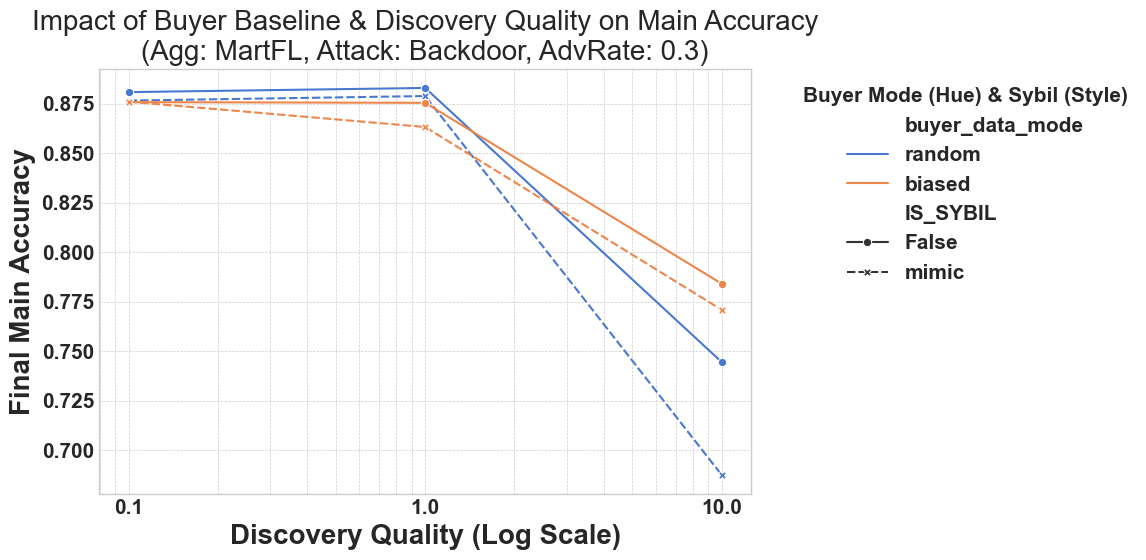

In [67]:
if not summary_df_avg.empty:
    # --- Select a specific aggregation and attack scenario ---
    ADV_RATE_TO_ANALYZE = 0.3

    focus_df = summary_df_avg[
        (summary_df_avg['AGGREGATION_METHOD'] == AGG_METHOD_TO_ANALYZE) &
        (summary_df_avg['attack_objective'] == ATTACK_TO_ANALYZE) &
        (summary_df_avg['ADV_RATE'] == ADV_RATE_TO_ANALYZE)
    ].copy()

    if not focus_df.empty:
        # Ensure discovery_quality is numeric for proper sorting/plotting if it's read as string
        focus_df['discovery_quality'] = pd.to_numeric(focus_df['discovery_quality'], errors='coerce')
        focus_df.dropna(subset=['discovery_quality'], inplace=True)


        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=focus_df,
            x='discovery_quality',
            y='FINAL_MAIN_ACC',
            hue='buyer_data_mode', # How buyer's baseline affects things
            style='IS_SYBIL',      # How sybil/mimic interacts
            markers=True,
            errorbar=('ci', 95) if 'FINAL_MAIN_ACC_STD' in focus_df.columns else None
        )
        plt.xscale('log') # Discovery quality might be on a log scale (0.1, 1.0, 10.0)
        plt.title(f'Impact of Buyer Baseline & Discovery Quality on Main Accuracy\n(Agg: {AGG_METHOD_TO_ANALYZE}, Attack: {ATTACK_TO_ANALYZE}, AdvRate: {ADV_RATE_TO_ANALYZE})')
        plt.xlabel('Discovery Quality (Log Scale)')
        plt.ylabel('Final Main Accuracy')
        plt.xticks(focus_df['discovery_quality'].unique(), labels=focus_df['discovery_quality'].unique()) # Show actual values
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(title='Buyer Mode (Hue) & Sybil (Style)', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for the specific scenario in Plot 7 (Agg: {AGG_METHOD_TO_ANALYZE}, etc.). Adjust filters.")
else:
    print("summary_df_avg is empty. Skipping Plot 7.")

Figure saved successfully to: ./results\paper_figures\martfl_gini_benign_varying_adv.pdf


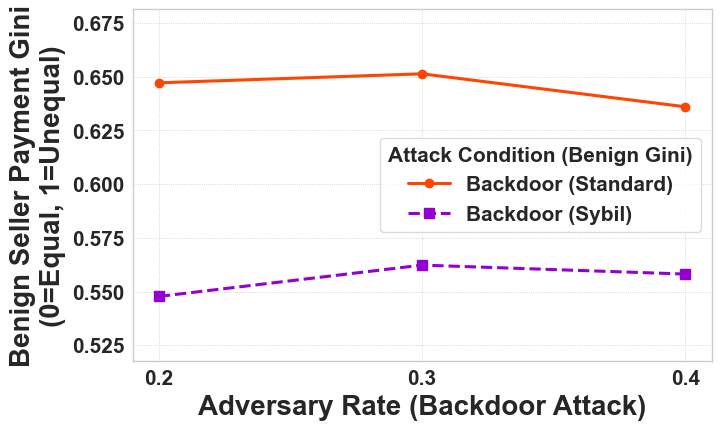

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Define the correct column name from your CSV
ACTUAL_BENIGN_GINI_COLUMN_NAME = 'AVG_BENIGN_PAYMENT_GINI'

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_benign_gini = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming 'MartFL'

    if ACTUAL_BENIGN_GINI_COLUMN_NAME not in plot_data_benign_gini.columns:
        print(f"Error (Benign Gini Plot): '{ACTUAL_BENIGN_GINI_COLUMN_NAME}' column not found. Cannot create plot.")
    elif plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME].isna().all():
        print(f"Error (Benign Gini Plot): '{ACTUAL_BENIGN_GINI_COLUMN_NAME}' column contains only NaN values. Cannot create plot.")
    else:
        # Column already preprocessed (numeric, rounded) by preprocess_experiment_data if listed in FLOAT_PRECISIONS
        # Ensure it's numeric if it wasn't in FLOAT_PRECISIONS, though it should be
        plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME] = pd.to_numeric(
            plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME], errors='coerce'
        )
        rows_before_dropna_bg = len(plot_data_benign_gini)
        plot_data_benign_gini.dropna(subset=[ACTUAL_BENIGN_GINI_COLUMN_NAME], inplace=True)
        if len(plot_data_benign_gini) < rows_before_dropna_bg:
            print(f"Plot Benign Gini: Dropped {rows_before_dropna_bg - len(plot_data_benign_gini)} rows with NaN {ACTUAL_BENIGN_GINI_COLUMN_NAME} values.")

        # 1. "No Attack" Benign Gini Baseline (Averaged over IS_SYBIL)
        no_attack_data_bg = plot_data_benign_gini[plot_data_benign_gini['attack_objective'] == 'No Attack'].copy()
        no_attack_avg_benign_gini = no_attack_data_bg[ACTUAL_BENIGN_GINI_COLUMN_NAME].mean() if not no_attack_data_bg.empty else np.nan

        # 2. "Backdoor Attack" Benign Gini Data, distinguishing IS_SYBIL
        adv_rates_to_plot_on_x = [0.2, 0.3, 0.4]
        backdoor_benign_gini_data = plot_data_benign_gini[
            (plot_data_benign_gini['attack_objective'] == 'Backdoor') &
            (plot_data_benign_gini['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        if not backdoor_benign_gini_data.empty:
            backdoor_benign_gini_by_sybil = backdoor_benign_gini_data.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )[ACTUAL_BENIGN_GINI_COLUMN_NAME].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_in_data = sorted(backdoor_benign_gini_by_sybil['ADV_RATE'].unique())
        else:
            print(f"Warning (Benign Gini Plot): No 'Backdoor' data for Benign Gini for ADV_RATEs {adv_rates_to_plot_on_x}.")
            backdoor_benign_gini_by_sybil = pd.DataFrame()
            adv_rates_present_in_data = []

        # --- Plotting Benign Gini ---
        if not backdoor_benign_gini_by_sybil.empty or pd.notna(no_attack_avg_benign_gini):
            fig, ax = plt.subplots()

            colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'orangered', 'Backdoor (Mimic)': 'darkviolet' }
            linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
            markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
            legend_elements_gini = []

            xmin_hline = min(adv_rates_present_in_data) if adv_rates_present_in_data else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_in_data) if adv_rates_present_in_data else max(adv_rates_to_plot_on_x)

            if pd.notna(no_attack_avg_benign_gini):
                ax.hlines(y=no_attack_avg_benign_gini, xmin=xmin_hline, xmax=xmax_hline,
                          color=colors['No Attack'], linestyle=linestyles['No Attack'])
                legend_elements_gini.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                                  lw=LINE_WIDTH, label=f'No Attack'))

            if not backdoor_benign_gini_by_sybil.empty:
                data_std = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'False']
                if not data_std.empty:
                    ax.plot(data_std['ADV_RATE'], data_std[ACTUAL_BENIGN_GINI_COLUMN_NAME], # Use actual name
                            color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                            marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH)
                    legend_elements_gini.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                                      marker=markers['Backdoor (Standard)'], lw=LINE_WIDTH,
                                                      label='Backdoor (Standard)'))

                data_mimic = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic.empty:
                    ax.plot(data_mimic['ADV_RATE'], data_mimic[ACTUAL_BENIGN_GINI_COLUMN_NAME], # Use actual name
                            color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                            marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_gini.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                                      marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                                      label='Backdoor (Sybil)'))

            ax.set_xlabel('Adversary Rate (Backdoor Attack)',)
            ax.set_ylabel('Benign Seller Payment Gini\n(0=Equal, 1=Unequal)')
            ax.tick_params(axis='both', which='major', pad=6)
            gini_values = backdoor_benign_gini_by_sybil[ACTUAL_BENIGN_GINI_COLUMN_NAME].tolist()
            if pd.notna(no_attack_avg_benign_gini):
                gini_values.append(no_attack_avg_benign_gini)
            
            if gini_values:
                min_val = max(min(gini_values) - 0.03, 0)
                max_val = min(max(gini_values) + 0.03, 1)
                ax.set_ylim(min_val, max_val)
            else:
                ax.set_ylim(0.2, 0.6)  # fallback range            
            plot_xticks_bg = adv_rates_present_in_data if adv_rates_present_in_data else adv_rates_to_plot_on_x
            if plot_xticks_bg :
                 ax.set_xticks(ticks=plot_xticks_bg); ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_bg])
            
            ax.grid(True, which='major', linestyle=':', linewidth=0.6)

            if legend_elements_gini:
                ax.legend(handles=legend_elements_gini, title='Attack Condition (Benign Gini)', loc='best', frameon=True, edgecolor='lightgray')
            # fig.suptitle(f'{current_aggregation_method}: Robustness of Benign Seller Fairness to Attacks',
            #              fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            fig = plt.gcf()
            save_figure_as_pdf(
                fig=fig, 
                output_directory=FIGURE_SAVE_DIR, 
                base_filename="gini_benign_varying_adv", # Base name describing the plot
                current_aggregation_method=current_aggregation_method,
                # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
            )              
else:
    print("DataFrame 'summary_df_avg' is not available for Benign Gini plot (empty or not loaded).")

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed by Cell 1.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_mal_select = summary_df_avg.copy()
    
    # Assuming AGGREGATION_METHOD is constant or you want to plot for a specific one.
    # If multiple, you might need to filter. For this example, taking the first one.
    aggregation_methods_present = plot_data_mal_select['AGGREGATION_METHOD'].unique()
    current_aggregation_method = aggregation_methods_present[0] if len(aggregation_methods_present) > 0 else "UnknownMethod"
    if len(aggregation_methods_present) > 1:
        print(f"Warning (Malicious Selection Plot): Multiple aggregation methods found. Plotting for '{current_aggregation_method}'. Filter if needed.")
        plot_data_mal_select = plot_data_mal_select[plot_data_mal_select['AGGREGATION_METHOD'] == current_aggregation_method]

    # Define required columns
    baseline_cols_map = {
        0.1: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1',
        0.2: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        0.3: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3',
        0.4: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    }
    actual_mal_select_col = 'AVG_ADVERSARY_SELECTION_RATE'
    
    # Check if all necessary columns exist
    missing_baseline_cols = [col for col in baseline_cols_map.values() if col not in plot_data_mal_select.columns]
    if actual_mal_select_col not in plot_data_mal_select.columns:
        missing_cols_error = f"Error: Column '{actual_mal_select_col}' not found. "
        if missing_baseline_cols:
            missing_cols_error += f"Additionally, baseline columns missing: {', '.join(missing_baseline_cols)}."
        print(missing_cols_error + " Cannot create plot.")
        # Set to empty to skip plotting
        plot_data_mal_select = pd.DataFrame() 
    elif missing_baseline_cols:
        print(f"Warning (Malicious Selection Plot): Some baseline columns missing: {', '.join(missing_baseline_cols)}. Baseline plot might be incomplete.")


    # Proceed only if we have the actual malicious selection rate column
    if not plot_data_mal_select.empty and actual_mal_select_col in plot_data_mal_select.columns:
        # Drop rows if the AVG_ADVERSARY_SELECTION_RATE is NaN for attack data,
        # or if ALL relevant NO_ATTACK_DESIG_MAL_SEL_RATE_X.X are NaN for No Attack data.
        
        # For attack data:
        attack_data_check = plot_data_mal_select[plot_data_mal_select['attack_objective'] == 'Backdoor']
        if not attack_data_check.empty:
            plot_data_mal_select.loc[plot_data_mal_select['attack_objective'] == 'Backdoor'] = \
                attack_data_check.dropna(subset=[actual_mal_select_col])
        
        # For no attack data (more complex as we use multiple baseline columns)
        # If a "No Attack" row has NaNs in ALL its NO_ATTACK_DESIG_MAL_SEL_RATE_X.X columns, it's not useful
        no_attack_rows = plot_data_mal_select['attack_objective'] == 'No Attack'
        baseline_col_names_in_df = [col for col in baseline_cols_map.values() if col in plot_data_mal_select.columns]
        if baseline_col_names_in_df: # Only if some baseline columns exist
             plot_data_mal_select = plot_data_mal_select[~(no_attack_rows & plot_data_mal_select[baseline_col_names_in_df].isna().all(axis=1))]


        # 1. Prepare "No Attack - Designated Group" Baseline Data
        no_attack_runs = plot_data_mal_select[plot_data_mal_select['attack_objective'] == 'No Attack'].copy()
        baseline_points = {} 
        if not no_attack_runs.empty:
            for adv_r_key, col_name in baseline_cols_map.items():
                if col_name in no_attack_runs.columns:
                    # Average over other variations (e.g. IS_SYBIL for "No Attack" runs)
                    mean_rate = no_attack_runs[col_name].mean() 
                    if pd.notna(mean_rate):
                        baseline_points[adv_r_key] = mean_rate
        del baseline_points[0.1 ]
        baseline_series_for_plot = pd.Series(baseline_points).sort_index()
        if baseline_series_for_plot.empty and not no_attack_runs.empty:
            print("Warning: Baseline series for 'No Attack' is empty after processing. Check NO_ATTACK_DESIG_MAL_SEL_RATE_X.X columns.")


        # 2. Prepare "Backdoor Attack" Data (Actual Malicious Selection Rate)
        # X-axis values for the attack lines should match the keys/index of baseline_series_for_plot
        adv_rates_for_attack_lines = baseline_series_for_plot.index.tolist() if not baseline_series_for_plot.empty else [0.2, 0.3, 0.4]

        backdoor_attack_data = plot_data_mal_select[
            (plot_data_mal_select['attack_objective'] == 'Backdoor') &
            (plot_data_mal_select['ADV_RATE'].isin(adv_rates_for_attack_lines))
        ].copy()

        actual_mal_select_by_sybil = pd.DataFrame() # Initialize
        if not backdoor_attack_data.empty:
            actual_mal_select_by_sybil = backdoor_attack_data.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )[actual_mal_select_col].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        else:
            print("Warning (Malicious Selection Plot): No 'Backdoor' attack data for plotting.")


        # --- Plotting ---
        if not actual_mal_select_by_sybil.empty or not baseline_series_for_plot.empty:
            LINE_WIDTH = 2.2; MARKER_SIZE = 7
        
            fig, ax = plt.subplots()
        
            color_no_atk_baseline = 'dimgray'
            color_std_atk = 'orangered'    # Standard Backdoor (IS_SYBIL='False')
            color_mimic_atk = 'darkviolet' # Mimicry Backdoor (IS_SYBIL='mimic')
        
            linestyle_no_atk_baseline = (0, (5, 2)) # Loosely Dotted
            linestyle_std_atk = '-'         # Solid
            linestyle_mimic_atk = '--'      # Dashed
        
            marker_no_atk_baseline = 'D'
            marker_std_atk = 'o'
            marker_mimic_atk = 's'
        
            legend_elements = []
        
            # 1. Plot Control Group (Designated Adv Group with No Attack)
            if not baseline_series_for_plot.empty:
                ax.plot(baseline_series_for_plot.index, baseline_series_for_plot.values,
                        color=color_no_atk_baseline, linestyle=linestyle_no_atk_baseline,
                        marker=marker_no_atk_baseline, linewidth=LINE_WIDTH, markersize=MARKER_SIZE-1)
                legend_elements.append(Line2D([0],[0], color=color_no_atk_baseline, linestyle=linestyle_no_atk_baseline,
                                              marker=marker_no_atk_baseline, markersize=MARKER_SIZE-1, lw=LINE_WIDTH,
                                              label='Control Group (Same Data, No Attack)'))
            else:
                print("No baseline data to plot for 'No Attack - Designated Group'.")
        
            # 2. Plot Attacker Group (Standard Backdoor)
            if not actual_mal_select_by_sybil.empty:
                data_std_backdoor = actual_mal_select_by_sybil[actual_mal_select_by_sybil['IS_SYBIL'] == 'False']
                if not data_std_backdoor.empty:
                    ax.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor[actual_mal_select_col],
                            color=color_std_atk, linestyle=linestyle_std_atk, marker=marker_std_atk,
                            linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements.append(Line2D([0],[0], color=color_std_atk, linestyle=linestyle_std_atk,
                                                  marker=marker_std_atk, markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label='Attacker Group (Standard Backdoor)'))
                else:
                    print("No data for Standard Backdoor (IS_SYBIL='False') line.")
        
                # 3. Plot Attacker Group (Sybil Backdoor)
                data_mimic_backdoor = actual_mal_select_by_sybil[actual_mal_select_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic_backdoor.empty:
                    ax.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor[actual_mal_select_col],
                            color=color_mimic_atk, linestyle=linestyle_mimic_atk, marker=marker_mimic_atk,
                            linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements.append(Line2D([0],[0], color=color_mimic_atk, linestyle=linestyle_mimic_atk,
                                                  marker=marker_mimic_atk, markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label='Attacker Group (Sybil Backdoor)'))
                else:
                    print("No data for Mimicry Backdoor (IS_SYBIL='mimic') line.")
        
            ax.set_xlabel('Adversary Rate')
            ax.set_ylabel('Avg. Selection Rate')
            ax.tick_params(axis='both', which='major', pad=6)
            selection_values = []
            
            # Add baseline (no attack control group) values
            if not baseline_series_for_plot.empty:
                selection_values.extend(baseline_series_for_plot.values.tolist())
            
            # Add standard backdoor values
            if not actual_mal_select_by_sybil.empty:
                std_data = actual_mal_select_by_sybil[actual_mal_select_by_sybil['IS_SYBIL'] == 'False']
                mimic_data = actual_mal_select_by_sybil[actual_mal_select_by_sybil['IS_SYBIL'] == 'mimic']
                if not std_data.empty:
                    selection_values.extend(std_data[actual_mal_select_col].tolist())
                if not mimic_data.empty:
                    selection_values.extend(mimic_data[actual_mal_select_col].tolist())
            
            # Set y-limits with ±padding, clipped to [0, 1]
            if selection_values:
                y_min = max(min(selection_values) - 0.03, 0)
                y_max = min(max(selection_values) + 0.03, 1)
                ax.set_ylim(y_min, y_max)
            else:
                ax.set_ylim(0, 1)  # fallback if no data
        
            plot_xticks = baseline_series_for_plot.index.tolist() if not baseline_series_for_plot.empty else adv_rates_to_plot_on_x
            if plot_xticks:
                ax.set_xticks(ticks=plot_xticks)
                ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks])
        
            ax.grid(True, which='major', linestyle=':', linewidth=0.6)
        
            if legend_elements:
                ax.legend(handles=legend_elements, title='Group & Behavior',
                          loc='best', frameon=True, edgecolor='lightgray')
        
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            save_figure_as_pdf(
                fig=fig, 
                output_directory=FIGURE_SAVE_DIR, 
                base_filename="selection_rate", 
                current_aggregation_method=current_aggregation_method,
            )
        else:
            print("Not enough data to plot Malicious Selection Rates after all filtering and preparation.")
else:
    print("DataFrame 'summary_df_avg' is not available (empty or not loaded). Skipping Malicious Selection Rate plot.")
    


KeyError: 0.1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed by Cell 1.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_speed = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Or get from df
    
    # --- CHOOSE THE ACCURACY MILESTONE TO PLOT ---
    CHOSEN_MILESTONE_LABEL = "80" # e.g., "70", "80", "85"
    rounds_col_to_plot = f'ROUNDS_TO_{CHOSEN_MILESTONE_LABEL}ACC'
    TARGET_ACC_VALUE = int(CHOSEN_MILESTONE_LABEL) / 100.0

    # Verify the chosen milestone column exists
    if rounds_col_to_plot not in plot_data_speed.columns:
        print(f"Error (Speed Plot): Column '{rounds_col_to_plot}' not found for the chosen milestone. Available ROUNDS_TO_XXACC columns:")
        print([col for col in plot_data_speed.columns if "ROUNDS_TO_" in col])
    elif plot_data_speed[rounds_col_to_plot].isna().all():
        print(f"Error (Speed Plot): Column '{rounds_col_to_plot}' is entirely NaN.")
    else:
        # Ensure data is numeric (should be from preprocessing)
        plot_data_speed[rounds_col_to_plot] = pd.to_numeric(plot_data_speed[rounds_col_to_plot], errors='coerce')
        
        # Handle NaNs in rounds_col_to_plot (meaning target not reached)
        # Option: Plot them at a high value (e.g., MAX_ROUNDS_EXECUTED from your summary + penalty)
        # For now, we will let NaNs break the lines, which clearly indicates non-convergence.
        # If you want to plot them high, uncomment and adjust:
        # MAX_ROUNDS_EXPERIMENT = summary_df_avg['TOTAL_ROUNDS_EXECUTED'].max() if 'TOTAL_ROUNDS_EXECUTED' in summary_df_avg else 200 # Default
        # plot_data_speed[rounds_col_to_plot].fillna(MAX_ROUNDS_EXPERIMENT + 10, inplace=True)


        # 1. "No Attack" - Rounds to Converge (averaged over IS_SYBIL for "No Attack")
        no_attack_speed_data = plot_data_speed[plot_data_speed['attack_objective'] == 'No Attack'].copy()
        no_attack_avg_rounds = no_attack_speed_data[rounds_col_to_plot].mean() if not no_attack_speed_data.empty else np.nan

        # 2. "Backdoor Attack" - Rounds to Converge, distinguishing IS_SYBIL
        adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4] # X-axis for attack lines
        backdoor_attack_speed_data = plot_data_speed[
            (plot_data_speed['attack_objective'] == 'Backdoor') &
            (plot_data_speed['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        backdoor_rounds_by_sybil = pd.DataFrame()
        adv_rates_present_speed = []
        if not backdoor_attack_speed_data.empty:
            backdoor_rounds_by_sybil = backdoor_attack_speed_data.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )[rounds_col_to_plot].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_speed = sorted(backdoor_rounds_by_sybil['ADV_RATE'].unique())
        else:
            print(f"Warning (Speed Plot): No 'Backdoor' data for {rounds_col_to_plot} at ADV_RATEs {adv_rates_to_plot_on_x}.")


        # --- Plotting Speed to Chosen Milestone ---
        if not backdoor_rounds_by_sybil.empty or pd.notna(no_attack_avg_rounds):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LEGEND_TITLE_FONT_SIZE = 11
            LINE_WIDTH = 2.2; MARKER_SIZE = 7

            fig, ax = plt.subplots()

            # Define visual properties for the 3 main conditions
            colors = {
                'No Attack': 'dimgray',
                'Backdoor (Standard)': 'saddlebrown', # IS_SYBIL = 'False'
                'Backdoor (Mimic)': 'darkgoldenrod'    # IS_SYBIL = 'mimic'
            }
            linestyles = {
                'No Attack': (0, (5, 2)),       # Loosely dotted baseline
                'Backdoor (Standard)': '-',     # Solid
                'Backdoor (Mimic)': '--'        # Dashed
            }
            markers = {
                'Backdoor (Standard)': 'o',
                'Backdoor (Mimic)': 's'
            }
            legend_elements_speed = []

            xmin_hline = min(adv_rates_present_speed) if adv_rates_present_speed else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_speed) if adv_rates_present_speed else max(adv_rates_to_plot_on_x)

            # 1. Plot "No Attack" Rounds Baseline
            if pd.notna(no_attack_avg_rounds):
                ax.hlines(y=no_attack_avg_rounds, xmin=xmin_hline, xmax=xmax_hline,
                          color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
                legend_elements_speed.append(Line2D([0],[0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                                  lw=LINE_WIDTH, label=f'No Attack ({no_attack_avg_rounds:.0f} Rnds)'))

            # 2. Plot "Backdoor Attack" Rounds for Standard (IS_SYBIL='False')
            if not backdoor_rounds_by_sybil.empty:
                data_std_backdoor = backdoor_rounds_by_sybil[backdoor_rounds_by_sybil['IS_SYBIL'] == 'False']
                if not data_std_backdoor.empty and not data_std_backdoor[rounds_col_to_plot].isna().all():
                    ax.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor[rounds_col_to_plot],
                            color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                            marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_speed.append(Line2D([0],[0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                                      marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE,
                                                      lw=LINE_WIDTH, label='Backdoor (Standard)'))
                else: print(f"No data or all NaN for Standard Backdoor for {rounds_col_to_plot}")

            # 3. Plot "Backdoor Attack" Rounds for Mimicry (IS_SYBIL='mimic')
                data_mimic_backdoor = backdoor_rounds_by_sybil[backdoor_rounds_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic_backdoor.empty and not data_mimic_backdoor[rounds_col_to_plot].isna().all():
                    ax.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor[rounds_col_to_plot],
                            color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                            marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_speed.append(Line2D([0],[0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                                      marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE,
                                                      lw=LINE_WIDTH, label='Backdoor (Sybil)'))
                else: print(f"No data or all NaN for Mimicry Backdoor for {rounds_col_to_plot}")


            ax.set_xlabel('Adversary Rate (Backdoor Attack)')
            ax.set_ylabel(f'Rounds to Reach {TARGET_ACC_VALUE*100:.0f}% Accuracy')
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            
            # Dynamic Y-axis limit based on data, ensuring 0 is the bottom if no negative values.
            all_y_values = []
            if pd.notna(no_attack_avg_rounds): all_y_values.append(no_attack_avg_rounds)
            if not backdoor_rounds_by_sybil.empty: all_y_values.extend(backdoor_rounds_by_sybil[rounds_col_to_plot].dropna().tolist())
            
            if all_y_values:
                min_y = 0
                max_y = max(all_y_values) * 1.1 if all_y_values else 200 # Default max if no data
                ax.set_ylim(min_y, max_y)
            else: # Fallback if no y-data at all
                ax.set_ylim(0,200)


            plot_xticks = adv_rates_present_speed if adv_rates_present_speed else adv_rates_to_plot_on_x
            if plot_xticks:
                 ax.set_xticks(ticks=plot_xticks)
                 ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks])
            
            ax.grid(True, which='major', linestyle=':', linewidth=0.6)

            if legend_elements_speed:
                ax.legend(handles=legend_elements_speed, title='Attack Condition (Convergence Speed)',
                          loc='best', frameon=True, edgecolor='lightgray')

            fig.suptitle(f'{current_aggregation_method}: Attack Impact on Convergence Speed to {TARGET_ACC_VALUE*100:.0f}% Acc.', y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Not enough data to plot speed to milestones after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping speed to milestones plot.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # For custom legend

# This cell depends on 'summary_df_avg' being loaded and preprocessed by Cell 1.
# It requires 'FINAL_ASR', 'ATTACK_METHOD', 'ADV_RATE', 'buyer_data_mode'.
# We will average over 'IS_SYBIL' for this particular plot for simplicity.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_asr_buyer = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming for title

    # Filter for only Backdoor attack scenarios
    plot_data_asr_buyer = plot_data_asr_buyer[
        plot_data_asr_buyer['attack_objective'] == 'Backdoor' # Focus on when attack is active
    ].copy()

    # Ensure required columns exist and are not all NaN
    required_metric_asr = 'FINAL_ASR'
    required_group_cols_asr = ['ADV_RATE', 'buyer_data_mode'] # IS_SYBIL will be averaged out
    
    all_needed_plot_cols_asr = [required_metric_asr] + required_group_cols_asr
    missing_plot_cols_asr = [col for col in all_needed_plot_cols_asr if col not in plot_data_asr_buyer.columns]

    if missing_plot_cols_asr:
        print(f"Error (Buyer Baseline ASR Plot): Columns missing: {', '.join(missing_plot_cols_asr)}.")
    elif plot_data_asr_buyer[required_metric_asr].isna().all():
        print(f"Error (Buyer Baseline ASR Plot): Metric column '{required_metric_asr}' is all NaN.")
    elif plot_data_asr_buyer.empty:
        print("Warning (Buyer Baseline ASR Plot): No 'Backdoor' attack data available after initial filtering.")
    else:
        # Data already numeric and rounded from Cell 1 preprocessing.
        # Drop rows if FINAL_ASR for this plot is NaN.
        plot_data_asr_buyer.dropna(subset=[required_metric_asr], inplace=True)

        # Group by ADV_RATE and buyer_data_mode, averaging over IS_SYBIL and any other variations
        if not plot_data_asr_buyer.empty:
            avg_asr_by_buyer_baseline = plot_data_asr_buyer.groupby(
                ['ADV_RATE', 'buyer_data_mode'], as_index=False
            )[required_metric_asr].mean().sort_values(by=['buyer_data_mode', 'ADV_RATE'])
            
            adv_rates_present_asr = sorted(avg_asr_by_buyer_baseline['ADV_RATE'].unique())
            # Ensure we only plot the ADV_RATEs we are interested in for attacks
            adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
            avg_asr_by_buyer_baseline = avg_asr_by_buyer_baseline[avg_asr_by_buyer_baseline['ADV_RATE'].isin(adv_rates_to_plot_on_x)]
            adv_rates_present_asr = sorted(avg_asr_by_buyer_baseline['ADV_RATE'].unique()) # Update after filtering
        else:
            print("Warning (Buyer Baseline ASR Plot): Data became empty after dropna on FINAL_ASR.")
            avg_asr_by_buyer_baseline = pd.DataFrame()
            adv_rates_present_asr = []

        # --- Plotting ASR vs. ADV_RATE by Buyer Baseline Type ---
        if not avg_asr_by_buyer_baseline.empty:
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LEGEND_TITLE_FONT_SIZE = 11
            LINE_WIDTH = 2.2; MARKER_SIZE = 7

            fig, ax = plt.subplots() # Single panel plot

            # Define visual properties for buyer_data_mode
            # Using more distinct colors now
            palette_buyer_mode = {'random': 'darkcyan', 'biased': 'sandybrown'}
            linestyle_buyer_mode = {'random': '-', 'biased': '--'}
            marker_buyer_mode = {'random': 'o', 'biased': 's'}

            legend_elements_asr = []

            for mode, group_df in avg_asr_by_buyer_baseline.groupby('buyer_data_mode'):
                # Ensure the mode from data exists in our defined palette/styles
                if mode in palette_buyer_mode:
                    ax.plot(group_df['ADV_RATE'], group_df['FINAL_ASR'],
                             color=palette_buyer_mode[mode],
                             linestyle=linestyle_buyer_mode[mode],
                             marker=marker_buyer_mode[mode],
                             linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    if mode == "random":
                        mode_name = "unbiased"
                    else:
                        mode_name = mode
                    legend_elements_asr.append(Line2D([0],[0], color=palette_buyer_mode[mode],
                                                      linestyle=linestyle_buyer_mode[mode], marker=marker_buyer_mode[mode],
                                                      lw=LINE_WIDTH, markersize=MARKER_SIZE,
                                                      label=f'Buyer Baseline: {mode_name.capitalize()}'))
                else:
                    print(f"Warning: Unexpected buyer_data_mode '{mode}' found. Skipping its ASR line.")


            ax.set_xlabel('Adversary Rate (Backdoor Attack)',)
            ax.set_ylabel('Final Attack Success Rate (ASR)',)
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            ax.set_ylim(-0.02, 1.02) # ASR is 0-1

            if adv_rates_present_asr:
                ax.set_xticks(ticks=adv_rates_present_asr)
                ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_asr])
            else: # Fallback if no data for specific ADV_RATEs
                ax.set_xticks(ticks=adv_rates_to_plot_on_x)
                ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x])

            ax.grid(True, which='major', linestyle=':', linewidth=0.6)

            if legend_elements_asr:
                ax.legend(handles=legend_elements_asr,
                           title='Buyer Baseline Type',
                           loc='best', frameon=True, edgecolor='lightgray') # 'best' or 'lower right' often good for ASR

            fig.suptitle(f'{current_aggregation_method}: Backdoor ASR by Buyer Baseline Quality', y=0.98, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            # plt.savefig(f"{current_aggregation_method}_asr_vs_buyer_baseline.pdf", bbox_inches='tight')
            plt.show()
        else:
            print("Not enough data to plot ASR by Buyer Baseline Impact after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping ASR by Buyer Baseline Impact plot.")

In [ ]:
# Ensure summary_df_avg is not empty and preprocessed
if summary_df_avg.empty:
    print("CRITICAL: summary_df_avg is empty. Cannot generate plots.")
else:
    print("\n--- Generating SIMPLIFIED Attack Performance Plots ---")
    print("Plotting Adversary Selection Rate vs. Adversary Rate (0.2, 0.3, 0.4), with lines for Data Discovery Quality.")
    print("Includes 'No Attack' baseline at ADV_RATE = 0.0.")

    # --- Configuration for these simplified plots ---
    # Define metrics to plot: (column_name, y_axis_label, plot_title_suffix)
    # We are focusing on Adversary Selection Rate as requested.
    metrics_to_plot = [
        ('AVG_ADVERSARY_SELECTION_RATE', 'Avg. Adversary Selection Rate', 'Adversary Selection Rate vs. Adversary Rate')
    ]

    # ADV_RATE values to display for active attacks
    target_adv_rates_active = [0.2, 0.3, 0.4]
    # All ADV_RATE values that will appear on the x-axis (including No Attack baseline)
    all_plot_adv_rates = sorted(list(set([0.0] + target_adv_rates_active)))


    # Get unique values for looping and consistent legend ordering
    aggregation_methods = sorted(summary_df_avg['AGGREGATION_METHOD'].unique())
    
    # Active attack methods (e.g., 'Backdoor', excluding 'No Attack' for main lines)
    active_attack_names = sorted([
        am for am in summary_df_avg['attack_objective'].unique() if am != 'No Attack'
    ])
    if not active_attack_names:
        print("Warning: No active attack methods found (e.g., 'Backdoor') in 'attack_objective' column.")
        print("Plots will only show 'No Attack' data if available.")

    # Ensure discovery_quality values are sorted numerically for the legend
    unique_dq_values = sorted(summary_df_avg['discovery_quality'].dropna().unique())
    discovery_quality_hue_order = [str(dq) for dq in unique_dq_values]

    # --- Plotting Loop ---
    for agg_method in aggregation_methods:
        for y_metric, y_label, title_suffix in metrics_to_plot:
            
            if y_metric not in summary_df_avg.columns:
                print(f"Metric '{y_metric}' not found in summary_df_avg. Skipping plot for {agg_method}.")
                continue

            plt.figure(figsize=(10, 6)) # Slightly smaller figure might be fine
            plot_has_data_for_metric = False 

            # 1. Plot lines for active attack methods (filtered for specific ADV_RATEs)
            df_active_attacks_filtered = summary_df_avg[
                (summary_df_avg['AGGREGATION_METHOD'] == agg_method) &
                (summary_df_avg['attack_objective'].isin(active_attack_names)) &
                (summary_df_avg['ADV_RATE'].isin(target_adv_rates_active)) # Key filter
            ].copy()

            if not df_active_attacks_filtered.empty:
                df_active_attacks_filtered['discovery_quality_cat'] = pd.Categorical(
                    df_active_attacks_filtered['discovery_quality'].astype(str),
                    categories=discovery_quality_hue_order,
                    ordered=True
                )
                df_active_attacks_filtered.sort_values(by=['attack_objective', 'discovery_quality_cat', 'ADV_RATE'], inplace=True)

                sns.lineplot(
                    data=df_active_attacks_filtered,
                    x='ADV_RATE',
                    y=y_metric,
                    hue='discovery_quality_cat',
                    style='attack_objective' if len(active_attack_names) > 1 else 'discovery_quality_cat',
                    markers=True,
                    ci=None,
                )
                plot_has_data_for_metric = True
            else:
                if active_attack_names:
                    print(f"No data for active attacks at ADV_RATEs {target_adv_rates_active} under Aggregation: {agg_method} for metric {y_metric}.")

            # 2. Plot 'No Attack' data as reference points (at ADV_RATE = 0.0)
            df_no_attack = summary_df_avg[
                (summary_df_avg['AGGREGATION_METHOD'] == agg_method) &
                (summary_df_avg['attack_objective'] == 'No Attack') &
                (summary_df_avg['ADV_RATE'] == 0.0) 
            ].copy()

            if not df_no_attack.empty:
                df_no_attack['discovery_quality_cat'] = pd.Categorical(
                    df_no_attack['discovery_quality'].astype(str),
                    categories=discovery_quality_hue_order,
                    ordered=True
                )
                df_no_attack.sort_values(by=['discovery_quality_cat'], inplace=True)
                
                sns.scatterplot(
                    data=df_no_attack,
                    x='ADV_RATE',
                    y=y_metric,
                    hue='discovery_quality_cat',
                    marker='X', 
                    s=150,      
                    legend=False, 
                    zorder=5      
                )
                # If there was no active attack data, but there IS 'No Attack' data,
                # we still want to show a legend for discovery_quality from these points.
                if not plot_has_data_for_metric and not df_no_attack.empty:
                    # Need to manually create a legend if only scatterplot points are shown
                    handles, labels = plt.gca().get_legend_handles_labels()
                    if not handles: # if scatterplot didn't auto-create handles (e.g. due to legend=False)
                                    # This part might need refinement if only scatter is plotted
                        # Create dummy lines for legend if only scatter points exist
                        # This is a bit of a hack, usually lineplot provides the primary legend
                        temp_handles = []
                        temp_labels = []
                        palette = sns.color_palette(n_colors=len(discovery_quality_hue_order))
                        color_map = {dq: palette[i] for i, dq in enumerate(discovery_quality_hue_order)}

                        for dq_val_str in df_no_attack['discovery_quality_cat'].unique():
                            if dq_val_str in color_map:
                                temp_handles.append(Line2D([0], [0], marker='X', color='w', label=str(dq_val_str),
                                                      markerfacecolor=color_map[dq_val_str], markersize=10))
                                temp_labels.append(str(dq_val_str))
                        if temp_handles:
                             plt.legend(handles=temp_handles, labels=temp_labels, title="Discovery Quality", bbox_to_anchor=(1.05, 1), loc='upper left')


                plot_has_data_for_metric = True # Even if only 'No Attack' data is plotted
            else:
                print(f"No 'No Attack' data found for Aggregation: {agg_method} for metric {y_metric} at ADV_RATE=0.")


            # --- Finalize Plot ---
            if plot_has_data_for_metric:
                title_parts = [title_suffix]
                if active_attack_names and not df_active_attacks_filtered.empty:
                    title_parts.append(f"(Active Attack(s): {', '.join(active_attack_names)})")
                title_parts.append(f"Aggregation: {agg_method}")
                
                plt.title('\n'.join(title_parts))
                plt.xlabel('Adversary Rate (ADV_RATE)')
                plt.ylabel(y_label)
                
                # Ensure legend exists and is correctly titled
                current_handles, current_labels = plt.gca().get_legend_handles_labels()
                if current_handles: # Only add legend if there are items to show
                    legend_title = "Discovery Quality"
                    if len(active_attack_names) > 1 and 'attack_objective' in df_active_attacks_filtered.columns:
                         pass # Seaborn's default title based on hue/style is usually fine
                    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

                plt.grid(True)
                plt.axhline(0, color='grey', linestyle=':', linewidth=0.8) 
                
                # Set specific x-axis ticks and limits
                plt.xticks(all_plot_adv_rates)
                plt.xlim(left=min(all_plot_adv_rates) - 0.05, right=max(all_plot_adv_rates) + 0.05)

                # Set y-axis limits for selection rate (0-1)
                if y_metric == 'AVG_ADVERSARY_SELECTION_RATE':
                    plt.ylim(bottom=-0.05, top=1.05)
                
                plt.tight_layout(rect=[0, 0, 0.85, 1]) 
                
                sanitized_agg_method = agg_method.replace(" ", "_").replace("/", "_")
                sanitized_y_metric = y_metric.replace(" ", "_").replace("/", "_")
                plot_filename = f"{OUTPUT_DIR}/plot_simplified_{sanitized_agg_method}_{sanitized_y_metric}_vs_ADV_RATE_by_DQ.png"
                try:
                    plt.savefig(plot_filename, bbox_inches='tight')
                    print(f"Saved plot: {plot_filename}")
                except Exception as e:
                    print(f"Error saving plot {plot_filename}: {e}")
                plt.show()
            else:
                plt.close() 

    print("--- Finished generating SIMPLIFIED attack performance plots ---")

'summary_df_avg' DataFrame is available.

--- Preparing Data for Figure A (Buyer Mode Impact) ---
Figure A saved to: ./results/paper_figures/fmnist_robustness_vs_buyer_mode_trig0.10_dq1.0.pdf


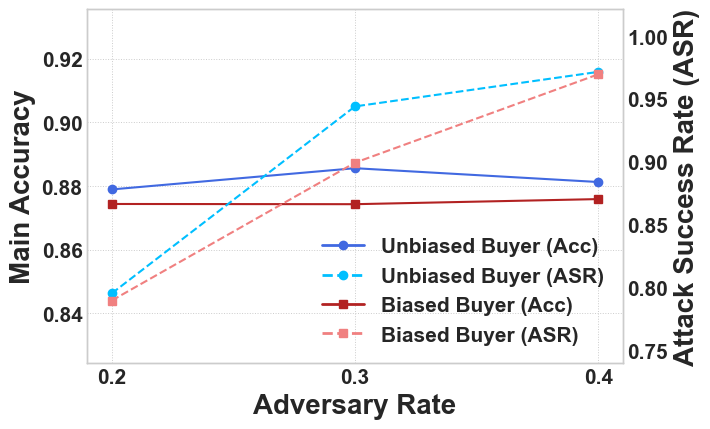


--- Preparing Data for Figure B (Seller Relevance Impact) ---
Figure B saved to: ./results/paper_figures/fmnist_robustness_vs_seller_relevance_trig0.10_adv0.3.pdf


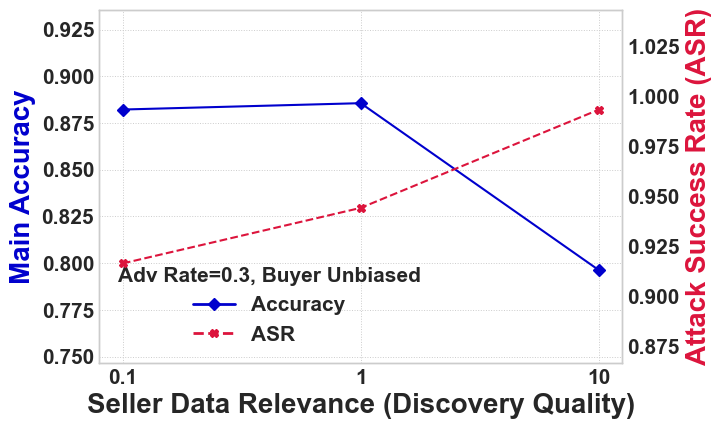

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D # For custom legend
import os

# --- Configuration ---
FMNIST_DATASET_NAME = 'FMNIST'
MARTFL_ALGO_NAME = 'martfl'
YOUR_BACKDOOR_ATTACK_NAME = 'Backdoor'
FIXED_TRIGGER_RATE = 0.1

# Figure (a) settings: Impact of Buyer Data Quality
MEDIUM_DISCOVERY_QUALITY_FOR_A = 1.0
UNBIASED_BUYER_MODE = 'random'
BIASED_BUYER_MODE = 'biased'
# X-axis for (a) is ADV_RATE, e.g., [0.1, 0.2, 0.3, 0.4]

# Figure (b) settings: Impact of Seller Data Relevance
DISCOVERY_QUALITY_LEVELS_FOR_B = sorted([0.1, 1.0, 10.0]) # X-axis for (b)
FIXED_ADV_RATE_FOR_B = 0.3
FIXED_BUYER_MODE_FOR_B = UNBIASED_BUYER_MODE

# --- Output Paths ---
BASE_SAVE_DIR = "./results/paper_figures/"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# Filenames (made more specific)
FILENAME_A = f"{BASE_SAVE_DIR}fmnist_robustness_vs_buyer_mode_trig{FIXED_TRIGGER_RATE:.2f}_dq{MEDIUM_DISCOVERY_QUALITY_FOR_A:.1f}.pdf"
FILENAME_B = f"{BASE_SAVE_DIR}fmnist_robustness_vs_seller_relevance_trig{FIXED_TRIGGER_RATE:.2f}_adv{FIXED_ADV_RATE_FOR_B:.1f}.pdf"


# --- Dummy Data for Testing (if summary_df_avg is not available) ---
if 'summary_df_avg' not in locals() or summary_df_avg.empty:
    print("CRITICAL ERROR: 'summary_df_avg' DataFrame not found. Using dummy data for layout.")
    adv_rates_a_axis = [0.1, 0.2, 0.3, 0.4]
    dummy_data_a_list = []
    for adv_rate in adv_rates_a_axis:
        for buyer_mode in [UNBIASED_BUYER_MODE, BIASED_BUYER_MODE]:
            dummy_data_a_list.append({
                'AGGREGATION_METHOD': MARTFL_ALGO_NAME, 'TRIGGER_RATE': FIXED_TRIGGER_RATE,
                'attack_objective': YOUR_BACKDOOR_ATTACK_NAME, 'ADV_RATE': adv_rate,
                'buyer_data_mode': buyer_mode, 'discovery_quality': MEDIUM_DISCOVERY_QUALITY_FOR_A,
                'FINAL_MAIN_ACC': np.random.uniform(0.5, 0.9), 'FINAL_ASR': np.random.uniform(0.1, 0.6)
            })
    dummy_df_a = pd.DataFrame(dummy_data_a_list)

    dummy_data_b_list = []
    for dq_level in DISCOVERY_QUALITY_LEVELS_FOR_B:
        dummy_data_b_list.append({
            'AGGREGATION_METHOD': MARTFL_ALGO_NAME, 'TRIGGER_RATE': FIXED_TRIGGER_RATE,
            'attack_objective': YOUR_BACKDOOR_ATTACK_NAME, 'ADV_RATE': FIXED_ADV_RATE_FOR_B,
            'buyer_data_mode': FIXED_BUYER_MODE_FOR_B, 'discovery_quality': dq_level,
            'FINAL_MAIN_ACC': np.random.uniform(0.6, 0.85) - (dq_level * 0.01 if dq_level <=1 else dq_level *0.005) , # Simulating relevance impact
            'FINAL_ASR': np.random.uniform(0.15, 0.5) + (dq_level * 0.01 if dq_level <=1 else dq_level *0.005)
        })
    dummy_df_b = pd.DataFrame(dummy_data_b_list)
    summary_df_avg = pd.concat([dummy_df_a, dummy_df_b], ignore_index=True).drop_duplicates()
else:
    print("'summary_df_avg' DataFrame is available.")

# --- Helper function for grouping and averaging ---
def get_averaged_data(df, group_by_cols, metrics_to_avg=['FINAL_MAIN_ACC', 'FINAL_ASR']):
    if df.empty:
        # print(f"Info: get_averaged_data received an empty DataFrame for groups: {group_by_cols}.")
        return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    actual_metrics_to_avg = [m for m in metrics_to_avg if m in df.columns]
    if not actual_metrics_to_avg:
        # print(f"Warning: None of metrics {metrics_to_avg} found for averaging. Group: {group_by_cols}")
        return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    df_cleaned = df.dropna(subset=actual_metrics_to_avg, how='any').copy()
    if df_cleaned.empty:
        # if not df.empty: print(f"Warning: Data became empty after dropping NaNs for metrics {actual_metrics_to_avg}. Group: {group_by_cols}")
        return pd.DataFrame(columns=group_by_cols + actual_metrics_to_avg)
    for metric in actual_metrics_to_avg: # Ensure numeric before mean
        df_cleaned[metric] = pd.to_numeric(df_cleaned[metric], errors='coerce')
    df_cleaned.dropna(subset=actual_metrics_to_avg, how='any', inplace=True)
    if df_cleaned.empty:
        # print(f"Warning: Data became empty after coercing metrics. Group: {group_by_cols}")
        return pd.DataFrame(columns=group_by_cols + actual_metrics_to_avg)
    averaged_df = df_cleaned.groupby(group_by_cols, as_index=False)[actual_metrics_to_avg].mean()
    if 'ADV_RATE' in group_by_cols and group_by_cols[0] == 'ADV_RATE':
        averaged_df = averaged_df.sort_values('ADV_RATE')
    elif 'discovery_quality' in group_by_cols and group_by_cols[0] == 'discovery_quality':
        averaged_df = averaged_df.sort_values('discovery_quality')
    return averaged_df

# --- Base Filtering (applied once) ---
base_filter_conditions = (
    (summary_df_avg['AGGREGATION_METHOD'].str.lower() == MARTFL_ALGO_NAME.lower()) &
    (summary_df_avg['TRIGGER_RATE'] == FIXED_TRIGGER_RATE) &
    (summary_df_avg['attack_objective'] == YOUR_BACKDOOR_ATTACK_NAME)
)
df_filtered_base_for_all = summary_df_avg[base_filter_conditions].copy()

if df_filtered_base_for_all.empty:
     print(f"Warning: No data found after applying common base filter. Plots may be empty.")


# --- FIGURE A: Impact of Buyer Data Quality ---
print("\n--- Preparing Data for Figure A (Buyer Mode Impact) ---")
df_a_filtered = df_filtered_base_for_all[
    (df_filtered_base_for_all['discovery_quality'] == MEDIUM_DISCOVERY_QUALITY_FOR_A) &
    (df_filtered_base_for_all['ADV_RATE'] > 0) # ADV_RATE > 0 for attack plots
].copy()

if df_a_filtered.empty:
    print(f"Warning: No data for Figure A after filtering for discovery_quality == {MEDIUM_DISCOVERY_QUALITY_FOR_A} and ADV_RATE > 0")

df_a_unbiased_avg = get_averaged_data(
    df_a_filtered[df_a_filtered['buyer_data_mode'] == UNBIASED_BUYER_MODE],
    group_by_cols=['ADV_RATE']
)
df_a_biased_avg = get_averaged_data(
    df_a_filtered[df_a_filtered['buyer_data_mode'] == BIASED_BUYER_MODE],
    group_by_cols=['ADV_RATE']
)
main_acc_color_attack = 'mediumblue'
asr_color_attack = 'crimson'
no_attack_acc_color = 'dimgray'  # Changed for better contrast with blue/red
no_attack_asr_color = 'salmon'  # Changed for better contrast

# --- Plotting Figure A ---
plt.style.use('seaborn-v0_8-whitegrid')

metrics_present_a_unbiased = all(m in df_a_unbiased_avg.columns for m in ['FINAL_MAIN_ACC', 'FINAL_ASR'])
metrics_present_a_biased = all(m in df_a_biased_avg.columns for m in ['FINAL_MAIN_ACC', 'FINAL_ASR'])

if not df_a_unbiased_avg.empty and not df_a_biased_avg.empty and metrics_present_a_unbiased and metrics_present_a_biased:
    fig_a, ax_a = plt.subplots() # Single panel
    ax_a_twin = ax_a.twinx()
    adv_rates_a_plot = sorted(pd.concat([df_a_unbiased_avg['ADV_RATE'], df_a_biased_avg['ADV_RATE']]).unique())

    ax_a.plot(df_a_unbiased_avg['ADV_RATE'], df_a_unbiased_avg['FINAL_MAIN_ACC'], marker='o', linestyle='-', color='royalblue', label='Unbiased Buyer (Acc)')
    ax_a_twin.plot(df_a_unbiased_avg['ADV_RATE'], df_a_unbiased_avg['FINAL_ASR'], marker='o', linestyle='--', color='deepskyblue', label='Unbiased Buyer (ASR)')

    ax_a.plot(df_a_biased_avg['ADV_RATE'], df_a_biased_avg['FINAL_MAIN_ACC'], marker='s', linestyle='-', color='firebrick', label='Biased Buyer (Acc)')
    ax_a_twin.plot(df_a_biased_avg['ADV_RATE'], df_a_biased_avg['FINAL_ASR'], marker='s', linestyle='--', color='lightcoral', label='Biased Buyer (ASR)')

    ax_a.set_xlabel('Adversary Rate')
    ax_a.set_ylabel('Main Accuracy')
    ax_a_twin.set_ylabel('Attack Success Rate (ASR)')
    ax_a.grid(True, linestyle=':', linewidth=0.7); ax_a_twin.grid(False)

    acc_vals_a = pd.concat([df_a_unbiased_avg['FINAL_MAIN_ACC'], df_a_biased_avg['FINAL_MAIN_ACC']]).dropna()
    asr_vals_a = pd.concat([df_a_unbiased_avg['FINAL_ASR'], df_a_biased_avg['FINAL_ASR']]).dropna()
    
    if not acc_vals_a.empty:
        acc_min, acc_max = acc_vals_a.min(), acc_vals_a.max()
        ax_a.set_ylim(
            bottom=max(acc_min - 0.05, 0),
            top=min(acc_max + 0.05, 1.05)
        )
    else:
        ax_a.set_ylim(0.4, 1.05)
    
    if not asr_vals_a.empty:
        asr_min, asr_max = asr_vals_a.min(), asr_vals_a.max()
        ax_a_twin.set_ylim(
            bottom=max(asr_min - 0.05, 0),
            top=min(asr_max + 0.05, 1.05)
        )
    else:
        ax_a_twin.set_ylim(0.0, 1.0)


    if adv_rates_a_plot:
        ax_a.set_xticks(ticks=adv_rates_a_plot)
        ax_a.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_a_plot])

    legend_elements_a = [
        Line2D([0], [0], color='royalblue', lw=2, linestyle='-', marker='o', label='Unbiased Buyer (Acc)'),
        Line2D([0], [0], color='deepskyblue', lw=2, linestyle='--', marker='o', label='Unbiased Buyer (ASR)'),
        Line2D([0], [0], color='firebrick', lw=2, linestyle='-', marker='s', label='Biased Buyer (Acc)'),
        Line2D([0], [0], color='lightcoral', lw=2, linestyle='--', marker='s', label='Biased Buyer (ASR)')
    ]
    ax_a.legend(handles=legend_elements_a, loc='lower right')
    # fig_a.suptitle(f'Impact of Buyer Data Quality (DQ fixed at {MEDIUM_DISCOVERY_QUALITY_FOR_A:.1f})', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    try:
        plt.savefig(FILENAME_A, bbox_inches='tight', dpi=300)
        print(f"Figure A saved to: {FILENAME_A}")
    except Exception as e:
        print(f"Error saving Figure A: {e}")
    plt.show()
else:
    print("Warning: Not enough averaged data for Figure A (Buyer Mode Impact). Plot not generated.")


# --- FIGURE B: Impact of Seller Data Relevance ---
print("\n--- Preparing Data for Figure B (Seller Relevance Impact) ---")
df_b_filtered = df_filtered_base_for_all[
    (df_filtered_base_for_all['ADV_RATE'] == FIXED_ADV_RATE_FOR_B) &
    (df_filtered_base_for_all['buyer_data_mode'] == FIXED_BUYER_MODE_FOR_B) &
    (df_filtered_base_for_all['discovery_quality'].isin(DISCOVERY_QUALITY_LEVELS_FOR_B))
].copy()

if df_b_filtered.empty:
    print(f"Warning: No data for Figure B after filtering for ADV_RATE={FIXED_ADV_RATE_FOR_B}, buyer_mode={FIXED_BUYER_MODE_FOR_B}, and DQ in {DISCOVERY_QUALITY_LEVELS_FOR_B}")

df_b_avg = get_averaged_data(
    df_b_filtered,
    group_by_cols=['discovery_quality'] # X-axis for figure (b)
)

# --- Plotting Figure B ---
metrics_present_b = all(m in df_b_avg.columns for m in ['FINAL_MAIN_ACC', 'FINAL_ASR'])

if not df_b_avg.empty and metrics_present_b:
    fig_b, ax_b = plt.subplots() # Single panel
    ax_b_twin = ax_b.twinx()

    discovery_qualities_to_plot_b = sorted(df_b_avg['discovery_quality'].unique())
    x_positions_b = np.arange(len(discovery_qualities_to_plot_b))

    ax_b.plot(x_positions_b, df_b_avg['FINAL_MAIN_ACC'], marker='D', linestyle='-', color=main_acc_color_attack, label='Accuracy')
    ax_b_twin.plot(x_positions_b, df_b_avg['FINAL_ASR'], marker='X', linestyle='--', color=asr_color_attack, label='ASR')

    ax_b.set_xlabel('Seller Data Relevance (Discovery Quality)')
    ax_b.set_ylabel('Main Accuracy', color=main_acc_color_attack)
    ax_b_twin.set_ylabel('Attack Success Rate (ASR)', color=asr_color_attack)
    ax_b.grid(True, linestyle=':', linewidth=0.7); ax_b_twin.grid(False)

    # --- Dynamically set Y-limits for Figure B ---
    acc_vals_b = df_b_avg['FINAL_MAIN_ACC'].dropna()
    asr_vals_b = df_b_avg['FINAL_ASR'].dropna()
    
    if not acc_vals_b.empty:
        acc_min_b, acc_max_b = acc_vals_b.min(), acc_vals_b.max()
        ax_b.set_ylim(
            bottom=max(acc_min_b - 0.05, 0),
            top=min(acc_max_b + 0.05, 1.05)
        )
    else:
        ax_b.set_ylim(0.4, 1.05)
    
    if not asr_vals_b.empty:
        asr_min_b, asr_max_b = asr_vals_b.min(), asr_vals_b.max()
        ax_b_twin.set_ylim(
            bottom=max(asr_min_b - 0.05, 0),
            top=min(asr_max_b + 0.05, 1.05)
        )
    else:
        ax_b_twin.set_ylim(0.0, 1.0)


    if discovery_qualities_to_plot_b:
        ax_b.set_xticks(ticks=x_positions_b)
        x_tick_labels_b = [f'{dq:.1f}' if dq < 1 else f'{int(dq)}' if dq == int(dq) else f'{dq:.1f}' for dq in discovery_qualities_to_plot_b]
        ax_b.set_xticklabels(labels=x_tick_labels_b)
    else: # Fallback for x-ticks
        fallback_x_pos_b = np.arange(len(DISCOVERY_QUALITY_LEVELS_FOR_B))
        ax_b.set_xticks(ticks=fallback_x_pos_b)
        ax_b.set_xticklabels(labels=[f'{dq:.1f}' if dq<1 else f'{int(dq)}' for dq in DISCOVERY_QUALITY_LEVELS_FOR_B], )


    legend_elements_b = [
        Line2D([0], [0], color=main_acc_color_attack, lw=2, linestyle='-', marker='D', label='Accuracy'),
        Line2D([0], [0], color=asr_color_attack, lw=2, linestyle='--', marker='X', label='ASR')
    ]
    ax_b.legend(handles=legend_elements_b, loc='best',
                title=f'Adv Rate={FIXED_ADV_RATE_FOR_B:.1f}, Buyer Unbiased')

    # fig_b.suptitle(f'Impact of Seller Data Relevance (Adv Rate fixed at {FIXED_ADV_RATE_FOR_B:.1f})', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    try:
        plt.savefig(FILENAME_B, bbox_inches='tight', dpi=300)
        print(f"Figure B saved to: {FILENAME_B}")
    except Exception as e:
        print(f"Error saving Figure B: {e}")
    plt.show()
else:
    print("Warning: Not enough averaged data for Figure B (Seller Relevance Impact). Plot not generated.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns # For a nice color palette

# --- Configuration ---
MARTFL_ALGO_NAME = 'martfl'
YOUR_BACKDOOR_ATTACK_NAME = 'Backdoor'

# Fixed parameters for these plots (ADJUST AS NEEDED FOR YOUR EXPERIMENT SET)
FIXED_DISCOVERY_QUALITY = 1.0
FIXED_BUYER_MODE = 'random' # Or 'biased', or whatever you want to fix
# ADV_RATES_TO_PLOT will be used for different lines/colors in each plot
ADV_RATES_TO_PLOT_AS_LINES = sorted([0.1, 0.2, 0.3, 0.4]) # Or other relevant adversary rates

# X-axis: Trigger Rates
# Ensure these trigger rates exist in your data.
# If they are continuous, the plot will connect points. If categorical, ensure data for each.
# For this example, let's assume trigger_rate is a continuous variable in your data
# or you have specific discrete values you ran experiments for.
# We will plot the unique trigger rates found in the filtered data.

# --- Output Paths ---
BASE_SAVE_DIR = "./results/paper_figures/trigger_rate_impact/"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

FILENAME_ASR_VS_TRIGGER = f"{BASE_SAVE_DIR}asr_vs_trigger_rate_dq{FIXED_DISCOVERY_QUALITY:.1f}_bm{FIXED_BUYER_MODE}.pdf"
FILENAME_MAL_SEL_VS_TRIGGER = f"{BASE_SAVE_DIR}mal_sel_vs_trigger_rate_dq{FIXED_DISCOVERY_QUALITY:.1f}_bm{FIXED_BUYER_MODE}.pdf"

# --- Dummy Data for Testing (if summary_df_avg is not available) ---
if 'summary_df_avg' not in locals() or summary_df_avg.empty:
    print("CRITICAL ERROR: 'summary_df_avg' DataFrame not found. Using dummy data.")
    dummy_data_list = []
    trigger_rates_dummy = np.linspace(0.05, 0.5, 5) # Example trigger rates
    for adv_rate in ADV_RATES_TO_PLOT_AS_LINES:
        for tr in trigger_rates_dummy:
            dummy_data_list.append({
                'AGGREGATION_METHOD': MARTFL_ALGO_NAME,
                'TRIGGER_RATE': tr,
                'attack_objective': YOUR_BACKDOOR_ATTACK_NAME,
                'ADV_RATE': adv_rate,
                'buyer_data_mode': FIXED_BUYER_MODE,
                'discovery_quality': FIXED_DISCOVERY_QUALITY,
                'FINAL_ASR': (adv_rate * 0.8 + tr * 1.5) * np.random.uniform(0.7, 1.0) if (adv_rate * 0.8 + tr * 1.5) < 1 else 0.95, # Simulating ASR increase
                'AVG_ADVERSARY_SELECTION_RATE': (adv_rate * 0.5 + tr * 0.2 + 0.1) * np.random.uniform(0.8,1.0) # Simulating selection
            })
    summary_df_avg = pd.DataFrame(dummy_data_list)
    summary_df_avg['FINAL_ASR'] = summary_df_avg['FINAL_ASR'].clip(0,1)
    summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'] = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].clip(0,1)
else:
    print("'summary_df_avg' DataFrame is available.")

# --- Helper function for grouping and averaging (same as before) ---
def get_averaged_data(df, group_by_cols, metrics_to_avg):
    if df.empty: return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    actual_metrics_to_avg = [m for m in metrics_to_avg if m in df.columns]
    if not actual_metrics_to_avg: return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    df_cleaned = df.dropna(subset=actual_metrics_to_avg, how='any').copy()
    if df_cleaned.empty: return pd.DataFrame(columns=group_by_cols + actual_metrics_to_avg)
    for metric in actual_metrics_to_avg:
        df_cleaned[metric] = pd.to_numeric(df_cleaned[metric], errors='coerce')
    df_cleaned.dropna(subset=actual_metrics_to_avg, how='any', inplace=True)
    if df_cleaned.empty: return pd.DataFrame(columns=group_by_cols + actual_metrics_to_avg)
    
    averaged_df = df_cleaned.groupby(group_by_cols, as_index=False)[actual_metrics_to_avg].mean()
    
    # Sort by the primary x-axis of the plot (which is TRIGGER_RATE here)
    if 'TRIGGER_RATE' in group_by_cols:
        averaged_df = averaged_df.sort_values('TRIGGER_RATE')
    return averaged_df

# --- Base Filtering ---
base_filter_conditions_trigger = (
    (summary_df_avg['AGGREGATION_METHOD'].str.lower() == MARTFL_ALGO_NAME.lower()) &
    (summary_df_avg['attack_objective'] == YOUR_BACKDOOR_ATTACK_NAME) &
    (summary_df_avg['discovery_quality'] == FIXED_DISCOVERY_QUALITY) &
    (summary_df_avg['buyer_data_mode'] == FIXED_BUYER_MODE) &
    (summary_df_avg['ADV_RATE'].isin(ADV_RATES_TO_PLOT_AS_LINES)) # Filter for specific ADV_RATEs to show as lines
    # TRIGGER_RATE will be the x-axis, so we don't filter it here initially
)
df_filtered_for_trigger_plots = summary_df_avg[base_filter_conditions_trigger].copy()

if df_filtered_for_trigger_plots.empty:
     print(f"Warning: No data found after applying base filter for trigger rate plots. Plots may be empty.")
     print(f"  Filters: AGG_METHOD='{MARTFL_ALGO_NAME}', ATTACK='{YOUR_BACKDOOR_ATTACK_NAME}', DQ={FIXED_DISCOVERY_QUALITY}, BM='{FIXED_BUYER_MODE}', ADV_RATES in {ADV_RATES_TO_PLOT_AS_LINES}")


# --- Data for FIGURE 1: ASR vs. Trigger Rate ---
print("\n--- Preparing Data for Figure 1 (ASR vs. Trigger Rate) ---")
metric_for_fig1 = 'FINAL_ASR'
# Group by TRIGGER_RATE (x-axis) and ADV_RATE (lines/hue)
# The get_averaged_data function will average over any other variations (e.g., seeds)
df_fig1_avg = get_averaged_data(
    df_filtered_for_trigger_plots,
    group_by_cols=['TRIGGER_RATE', 'ADV_RATE'], # ADV_RATE will differentiate lines
    metrics_to_avg=[metric_for_fig1]
)

# --- Plotting FIGURE 1: ASR vs. Trigger Rate ---
plt.style.use('seaborn-v0_8-whitegrid')
palette = sns.color_palette("viridis", n_colors=len(ADV_RATES_TO_PLOT_AS_LINES)) # Or "mako", "rocket"


if not df_fig1_avg.empty and metric_for_fig1 in df_fig1_avg.columns:
    fig1, ax1 = plt.subplots()
    
    for i, adv_rate in enumerate(ADV_RATES_TO_PLOT_AS_LINES):
        data_for_line = df_fig1_avg[df_fig1_avg['ADV_RATE'] == adv_rate]
        if not data_for_line.empty:
            ax1.plot(data_for_line['TRIGGER_RATE'], data_for_line[metric_for_fig1],
                     marker='o', linestyle='-', color=palette[i],
                     label=f'Adv. Rate = {adv_rate:.1f}')

    ax1.set_xlabel('Trigger Pattern Rate (Intensity)')
    ax1.set_ylabel('Final Attack Success Rate (ASR)')
    ax1.grid(True, linestyle=':', linewidth=0.7)
    ax1.set_ylim(bottom=-0.02, top=1.02)
    
    # X-ticks: Show unique trigger rates from data or define explicitly
    unique_trigger_rates_plot1 = sorted(df_fig1_avg['TRIGGER_RATE'].unique())
    if unique_trigger_rates_plot1:
        ax1.set_xticks(ticks=unique_trigger_rates_plot1)
        ax1.set_xticklabels(labels=[f'{tr:.2f}' for tr in unique_trigger_rates_plot1], rotation=0, ha="right")

    ax1.legend(title='Adversary Rate', loc='best', )
    fig1.suptitle(f'ASR vs. Trigger Rate (DQ={FIXED_DISCOVERY_QUALITY:.1f}, Buyer={FIXED_BUYER_MODE.capitalize()})', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    try:
        plt.savefig(FILENAME_ASR_VS_TRIGGER, bbox_inches='tight', dpi=300)
        print(f"Figure 1 (ASR vs Trigger Rate) saved to: {FILENAME_ASR_VS_TRIGGER}")
    except Exception as e:
        print(f"Error saving Figure 1: {e}")
    plt.show()
else:
    print("Warning: Not enough averaged data for Figure 1 (ASR vs. Trigger Rate). Plot not generated.")


# --- Data for FIGURE 2: Malicious Selection Rate vs. Trigger Rate ---
print("\n--- Preparing Data for Figure 2 (Malicious Selection vs. Trigger Rate) ---")
metric_for_fig2 = 'AVG_ADVERSARY_SELECTION_RATE'
df_fig2_avg = get_averaged_data(
    df_filtered_for_trigger_plots,
    group_by_cols=['TRIGGER_RATE', 'ADV_RATE'],
    metrics_to_avg=[metric_for_fig2]
)

# --- Plotting FIGURE 2: Malicious Selection Rate vs. Trigger Rate ---
if not df_fig2_avg.empty and metric_for_fig2 in df_fig2_avg.columns:
    fig2, ax2 = plt.subplots()

    for i, adv_rate in enumerate(ADV_RATES_TO_PLOT_AS_LINES):
        data_for_line = df_fig2_avg[df_fig2_avg['ADV_RATE'] == adv_rate]
        if not data_for_line.empty:
            ax2.plot(data_for_line['TRIGGER_RATE'], data_for_line[metric_for_fig2],
                     marker='s', linestyle='--', color=palette[i], # Different marker/linestyle
                     label=f'Adv. Rate = {adv_rate:.1f}')

    ax2.set_xlabel('Trigger Pattern Rate (Intensity)')
    ax2.set_ylabel('Avg. Adversary Selection Rate')
    ax2.grid(True, linestyle=':', linewidth=0.7)
    ax2.set_ylim(bottom=-0.02, top=1.02) # Selection rate is also 0-1

    unique_trigger_rates_plot2 = sorted(df_fig2_avg['TRIGGER_RATE'].unique())
    if unique_trigger_rates_plot2:
        ax2.set_xticks(ticks=unique_trigger_rates_plot2)
        ax2.set_xticklabels(labels=[f'{tr:.2f}' for tr in unique_trigger_rates_plot2], rotation=0, ha="right")

    ax2.legend(title='Adversary Rate', loc='best')
    fig2.suptitle(f'Adversary Selection vs. Trigger Rate (DQ={FIXED_DISCOVERY_QUALITY:.1f}, Buyer={FIXED_BUYER_MODE.capitalize()})', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    try:
        plt.savefig(FILENAME_MAL_SEL_VS_TRIGGER, bbox_inches='tight', dpi=300)
        print(f"Figure 2 (Malicious Selection vs Trigger Rate) saved to: {FILENAME_MAL_SEL_VS_TRIGGER}")
    except Exception as e:
        print(f"Error saving Figure 2: {e}")
    save_figure_as_pdf(
        fig=fig2, 
        output_directory=FIGURE_SAVE_DIR, 
        base_filename="asr_trigger_rate", # Base name describing the plot
        current_aggregation_method=current_aggregation_method,
        # other_details=f"target{int(TARGET_ACCURACY_COC*100)}acc" # Example other detail
    )
    plt.show()
else:
    print("Warning: Not enough averaged data for Figure 2 (Malicious Selection vs. Trigger Rate). Plot not generated.")